# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import json
from torch import save, load

# Dataset

In [3]:
seed = 2133330296#randint(0, 4294967295)
print(seed)

2133330296


In [4]:
df = pd.read_csv('data/churn/customer_churn_telecom_services.csv', header=0)
print('Nº de instâncias:', len(df))
df.head()

Nº de instâncias: 7043


gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [5]:
# Quantiades de cada valor único por coluna
nmrc_cols = []
cat_cols = []

for col in df.drop(columns=['Churn']).columns:
    unique_values = df[col].value_counts()
    if(len(unique_values) <= 4):
        print(unique_values, '\n')
        #df[col] = df[col].astype('category')
        cat_cols.append(col)
    else:
        nmrc_cols.append(col)

gender
Male      3555
Female    3488
Name: count, dtype: int64 

SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64 

OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64 

DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64 

TechSupport
No                     3473
Yes                    2044
No internet ser

In [6]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Alterando colunas categóricas binárias para int

#df_train1['gender'] = df_train1['gender'].apply(lambda x: 0 if x=='Male' else 1)

rdict = {'gender': {'Male': 0, 'Female': 1}, 
         'Partner': {'No': 0, 'Yes': 1},
         'Dependents': {'No': 0, 'Yes': 1},
         'PhoneService': {'No': 0, 'Yes': 1},
         'PaperlessBilling': {'No': 0, 'Yes': 1},
         'Churn': {'No': 0, 'Yes': 1},
         }

# Alterando colunas que são parcialmente dummy
# Exp.: OnlineSecurity: ("No internet service", "No", "Yes") -> (0, 1, 2)

rdict['MultipleLines'] = {'No phone service': 0, 'No': 1, 'Yes': 2}

cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
        'StreamingTV', 'StreamingMovies']

for col in cols:
    rdict[col] = {'No internet service': 0, 'No': 1, 'Yes': 2}

# Alterando colunas não-dummy

rdict['InternetService'] = {'No': 0, 'DSL': 1, 'Fiber optic': 2}

rdict['Contract'] = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}

rdict['PaymentMethod'] = {'Credit card (automatic)': 0, 'Bank transfer (automatic)': 1,
                          'Mailed check': 2, 'Electronic check': 3}

df = df.replace(rdict).rename(columns={'Churn': 'target'})
df.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_17116\3383695723.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(rdict).rename(columns={'Churn': 'target'})


gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       1              0        1           0       1             0   
1       0              0        0           0      34             1   
2       0              0        0           0       2             1   
3       0              0        0           0      45             0   
4       1              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              0                1               1             2   
1              1                1               2             1   
2              1                1               2             2   
3              0                1               2             1   
4              1                2               1             1   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 1            1            1                1         0   
1                 2            1            1                1         1   
2                 1            1            1                1         0   
3                 2            2            1                1         1   
4                 1            1            1                1         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  target  
0                 1              3           29.85         29.85       0  
1                 0              2           56.95       1889.50       0  
2                 1              2           53.85        108.15       1  
3                 0              1           42.30       1840.75       0  
4                 1              3           70.70        151.65       1

In [7]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5
cols = df.drop(columns=['target']).columns

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [8]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
#Xa_test_norm = scaler.transform(Xa_test)

In [9]:
# Normalização no conjunto de treinamento
scaler1 = MinMaxScaler()

Xb_train_norm = Xb_train.copy()
Xb_train_norm.loc[:,nmrc_cols] = scaler1.fit_transform(Xb_train_norm.loc[:,nmrc_cols], yb_train)

# Normalização nos conjuntos de validação e teste, com base nos dados de treinamento
Xb_test_norm = Xb_test.copy()
Xb_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xb_test_norm.loc[:,nmrc_cols])

Xa_test_norm = Xa_test.copy()
Xa_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xa_test_norm.loc[:,nmrc_cols])

Xb_train_norm.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_17116\62727071.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.75       0.76388889 0.875      ... 0.90277778 0.23611111 0.04166667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xb_train_norm.loc[:,nmrc_cols] = scaler1.fit_transform(Xb_train_norm.loc[:,nmrc_cols], yb_train)
C:\Users\pedro\AppData\Local\Temp\ipykernel_17116\62727071.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.31944444 0.06944444 0.23611111 ... 0.98611111 0.33333333 0.51388889]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Xb_test_norm.loc[:,nmrc_cols] = scaler1.transform(Xb_test_norm.loc[:,nmrc_cols])
C:\Users\pedro\AppData\Local\Temp\ipykernel_17116\62727071.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
1819       0              0        1           1  0.750000             1   
1364       0              1        0           0  0.763889             1   
1898       1              0        1           0  0.875000             1   
2046       0              0        0           0  0.138889             1   
2082       0              0        1           1  0.250000             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
1819              2                1               2             2   
1364              2                2               2             2   
1898              1                2               2             1   
2046              1                2               2             1   
2082              1                2               1             1   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
1819                 1            2            1                1         2   
1364                 2            2            2                2         0   
1898                 2            1            1                1         1   
2046                 2            1            2                2         1   
2082                 1            2            1                2         0   

      PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  
1819                 1              0        0.472347      0.410683  
1364                 1              3        0.979073      0.734910  
1898                 1              0        0.626806      0.601568  
2046                 1              3        0.803687      0.122622  
2082                 1              3        0.671151      0.184403

In [10]:
# Balanceamento no conjunto de treinamento
o_sampler = RandomOverSampler(random_state=seed)

yb_train_norm = yb_train.copy()
Xb_train, yb_train = o_sampler.fit_resample(Xb_train, yb_train)
Xb_train_norm, yb_train_norm = o_sampler.fit_resample(Xb_train_norm, yb_train_norm)

# Base Models

In [11]:
performs = {}
models_error = pd.DataFrame()
models = []

In [12]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [13]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

KeyboardInterrupt: 

In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.9972
Recall:           0.9994
Precision:        0.9949
F1:               0.9972
AUROC:            0.9999
AUPR:             0.9999
1-maxProb média:  0.0028
1-maxProb dp:     0.0217

[Testing]

Accuracy:         0.7286
Recall:           0.4780
Precision:        0.4579
F1:               0.4678
AUROC:            0.6461
AUPR:             0.3496
1-maxProb média:  0.0015
1-maxProb dp:     0.0204


In [ ]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0    1.0
1    0.0
2    1.0
3    1.0
4    0.0

In [ ]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [ ]:
sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l2'}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.7741
Recall:           0.8103
Precision:        0.7557
F1:               0.7820
AUROC:            0.8507
AUPR:             0.8278
1-maxProb média:  0.2424
1-maxProb dp:     0.1493

[Testing]

Accuracy:         0.7473
Recall:           0.7984
Precision:        0.4960
F1:               0.6118
AUROC:            0.8414
AUPR:             0.6361
1-maxProb média:  0.2316
1-maxProb dp:     0.1617


### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.7795
Recall:           0.8154
Precision:        0.7608
F1:               0.7871
AUROC:            0.8531
AUPR:             0.8298
1-maxProb média:  0.2261
1-maxProb dp:     0.1368

[Testing]

Accuracy:         0.7485
Recall:           0.7984
Precision:        0.4975
F1:               0.6130
AUROC:            0.8423
AUPR:             0.6338
1-maxProb média:  0.2194
1-maxProb dp:     0.1456


### K-Nearest Neighbors

(KNN)

In [ ]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0008
1-maxProb dp:     0.0168

[Testing]

Accuracy:         0.6974
Recall:           0.6407
Precision:        0.4287
F1:               0.5137
AUROC:            0.7423
AUPR:             0.4387
1-maxProb média:  0.1187
1-maxProb dp:     0.1654


### Support Vector Machine - Linear
(SVM)

In [ ]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 1}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.7685
Recall:           0.8159
Precision:        0.7452
F1:               0.7790
AUROC:            0.8523
AUPR:             0.8261
1-maxProb média:  0.2251
1-maxProb dp:     0.1278

[Testing]

Accuracy:         0.7355
Recall:           0.8114
Precision:        0.4821
F1:               0.6048
AUROC:            0.8403
AUPR:             0.6327
1-maxProb média:  0.2193
1-maxProb dp:     0.1408


### Support Vector Machine - Polynomial
(SVM)

In [ ]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 10, 'degree': 4, 'gamma': 'scale'}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9054
Recall:           0.9385
Precision:        0.8803
F1:               0.9084
AUROC:            0.9497
AUPR:             0.9235
1-maxProb média:  0.1847
1-maxProb dp:     0.1107

[Testing]

Accuracy:         0.7331
Recall:           0.6520
Precision:        0.4746
F1:               0.5493
AUROC:            0.7639
AUPR:             0.5035
1-maxProb média:  0.1781
1-maxProb dp:     0.1387


### Support Vector Machine - RBF
(SVM)

In [ ]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 10, 'gamma': 'scale'}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.8608
Recall:           0.9260
Precision:        0.8192
F1:               0.8693
AUROC:            0.9321
AUPR:             0.9022
1-maxProb média:  0.1724
1-maxProb dp:     0.1119

[Testing]

Accuracy:         0.7387
Recall:           0.7463
Precision:        0.4847
F1:               0.5877
AUROC:            0.8062
AUPR:             0.5498
1-maxProb média:  0.1758
1-maxProb dp:     0.1363


### Multi-Layer Perceptron
(MLP)

In [ ]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9780
Recall:           0.9876
Precision:        0.9690
F1:               0.9782
AUROC:            0.9986
AUPR:             0.9986
1-maxProb média:  0.0339
1-maxProb dp:     0.0903

[Testing]

Accuracy:         0.7432
Recall:           0.5398
Precision:        0.4868
F1:               0.5120
AUROC:            0.7672
AUPR:             0.4785
1-maxProb média:  0.0636
1-maxProb dp:     0.1243


### Kolmogorov-Arnold Network
(KAN)

In [ ]:
kan_cv = 0#int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [ ]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/churn.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/churn.pkl')
    save(kanet.state_dict(), 'kan_params/churn.pt')
else:
    with open('kan_params/churn.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/churn.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[13, 0], [20, 0], [2, 0]],
grid: 8,
lr: 0.0001,
lamb: 0.005


In [ ]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         0.7665
Recall:           0.7730
Precision:        0.7631
F1:               0.7680
AUROC:            0.8434
AUPR:             0.8203
1-maxProb média:  0.2488
1-maxProb dp:     0.1175

[Testing]

Accuracy:         0.7444
Recall:           0.7561
Precision:        0.4921
F1:               0.5962
AUROC:            0.8296
AUPR:             0.6250
1-maxProb média:  0.2417
1-maxProb dp:     0.1244


### Random Forest

In [ ]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9992
Recall:           1.0000
Precision:        0.9983
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0609
1-maxProb dp:     0.0842

[Testing]

Accuracy:         0.7822
Recall:           0.6000
Precision:        0.5591
F1:               0.5788
AUROC:            0.8171
AUPR:             0.5820
1-maxProb média:  0.1949
1-maxProb dp:     0.1567


### Gradient Boosting

In [ ]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 150}


In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9992
Recall:           0.9994
Precision:        0.9989
F1:               0.9992
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0009
1-maxProb dp:     0.0167

[Testing]

Accuracy:         0.7744
Recall:           0.5154
Precision:        0.5513
F1:               0.5328
AUROC:            0.8063
AUPR:             0.5779
1-maxProb média:  0.0414
1-maxProb dp:     0.1001


### AdaBoost

In [ ]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'learning_rate': 1, 'n_estimators': 150}


In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8077
Recall:           0.8413
Precision:        0.7884
F1:               0.8140
AUROC:            0.8842
AUPR:             0.8651
1-maxProb média:  0.4954
1-maxProb dp:     0.0088

[Testing]

Accuracy:         0.7562
Recall:           0.7707
Precision:        0.5075
F1:               0.6120
AUROC:            0.8324
AUPR:             0.6130
1-maxProb média:  0.4948
1-maxProb dp:     0.0093


### XGBoost

In [ ]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 150}


In [ ]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         0.9986
Recall:           1.0000
Precision:        0.9972
F1:               0.9986
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0313
1-maxProb dp:     0.0438

[Testing]

Accuracy:         0.7748
Recall:           0.6065
Precision:        0.5437
F1:               0.5734
AUROC:            0.8112
AUPR:             0.5669
1-maxProb média:  0.0994
1-maxProb dp:     0.1318


## Análise de Correlações

In [ ]:
groups = {}
model_names = list(performs.keys())

In [ ]:
pred_corrls = pd.DataFrame(columns=models_error.columns, index=models_error.columns, dtype=float)

ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


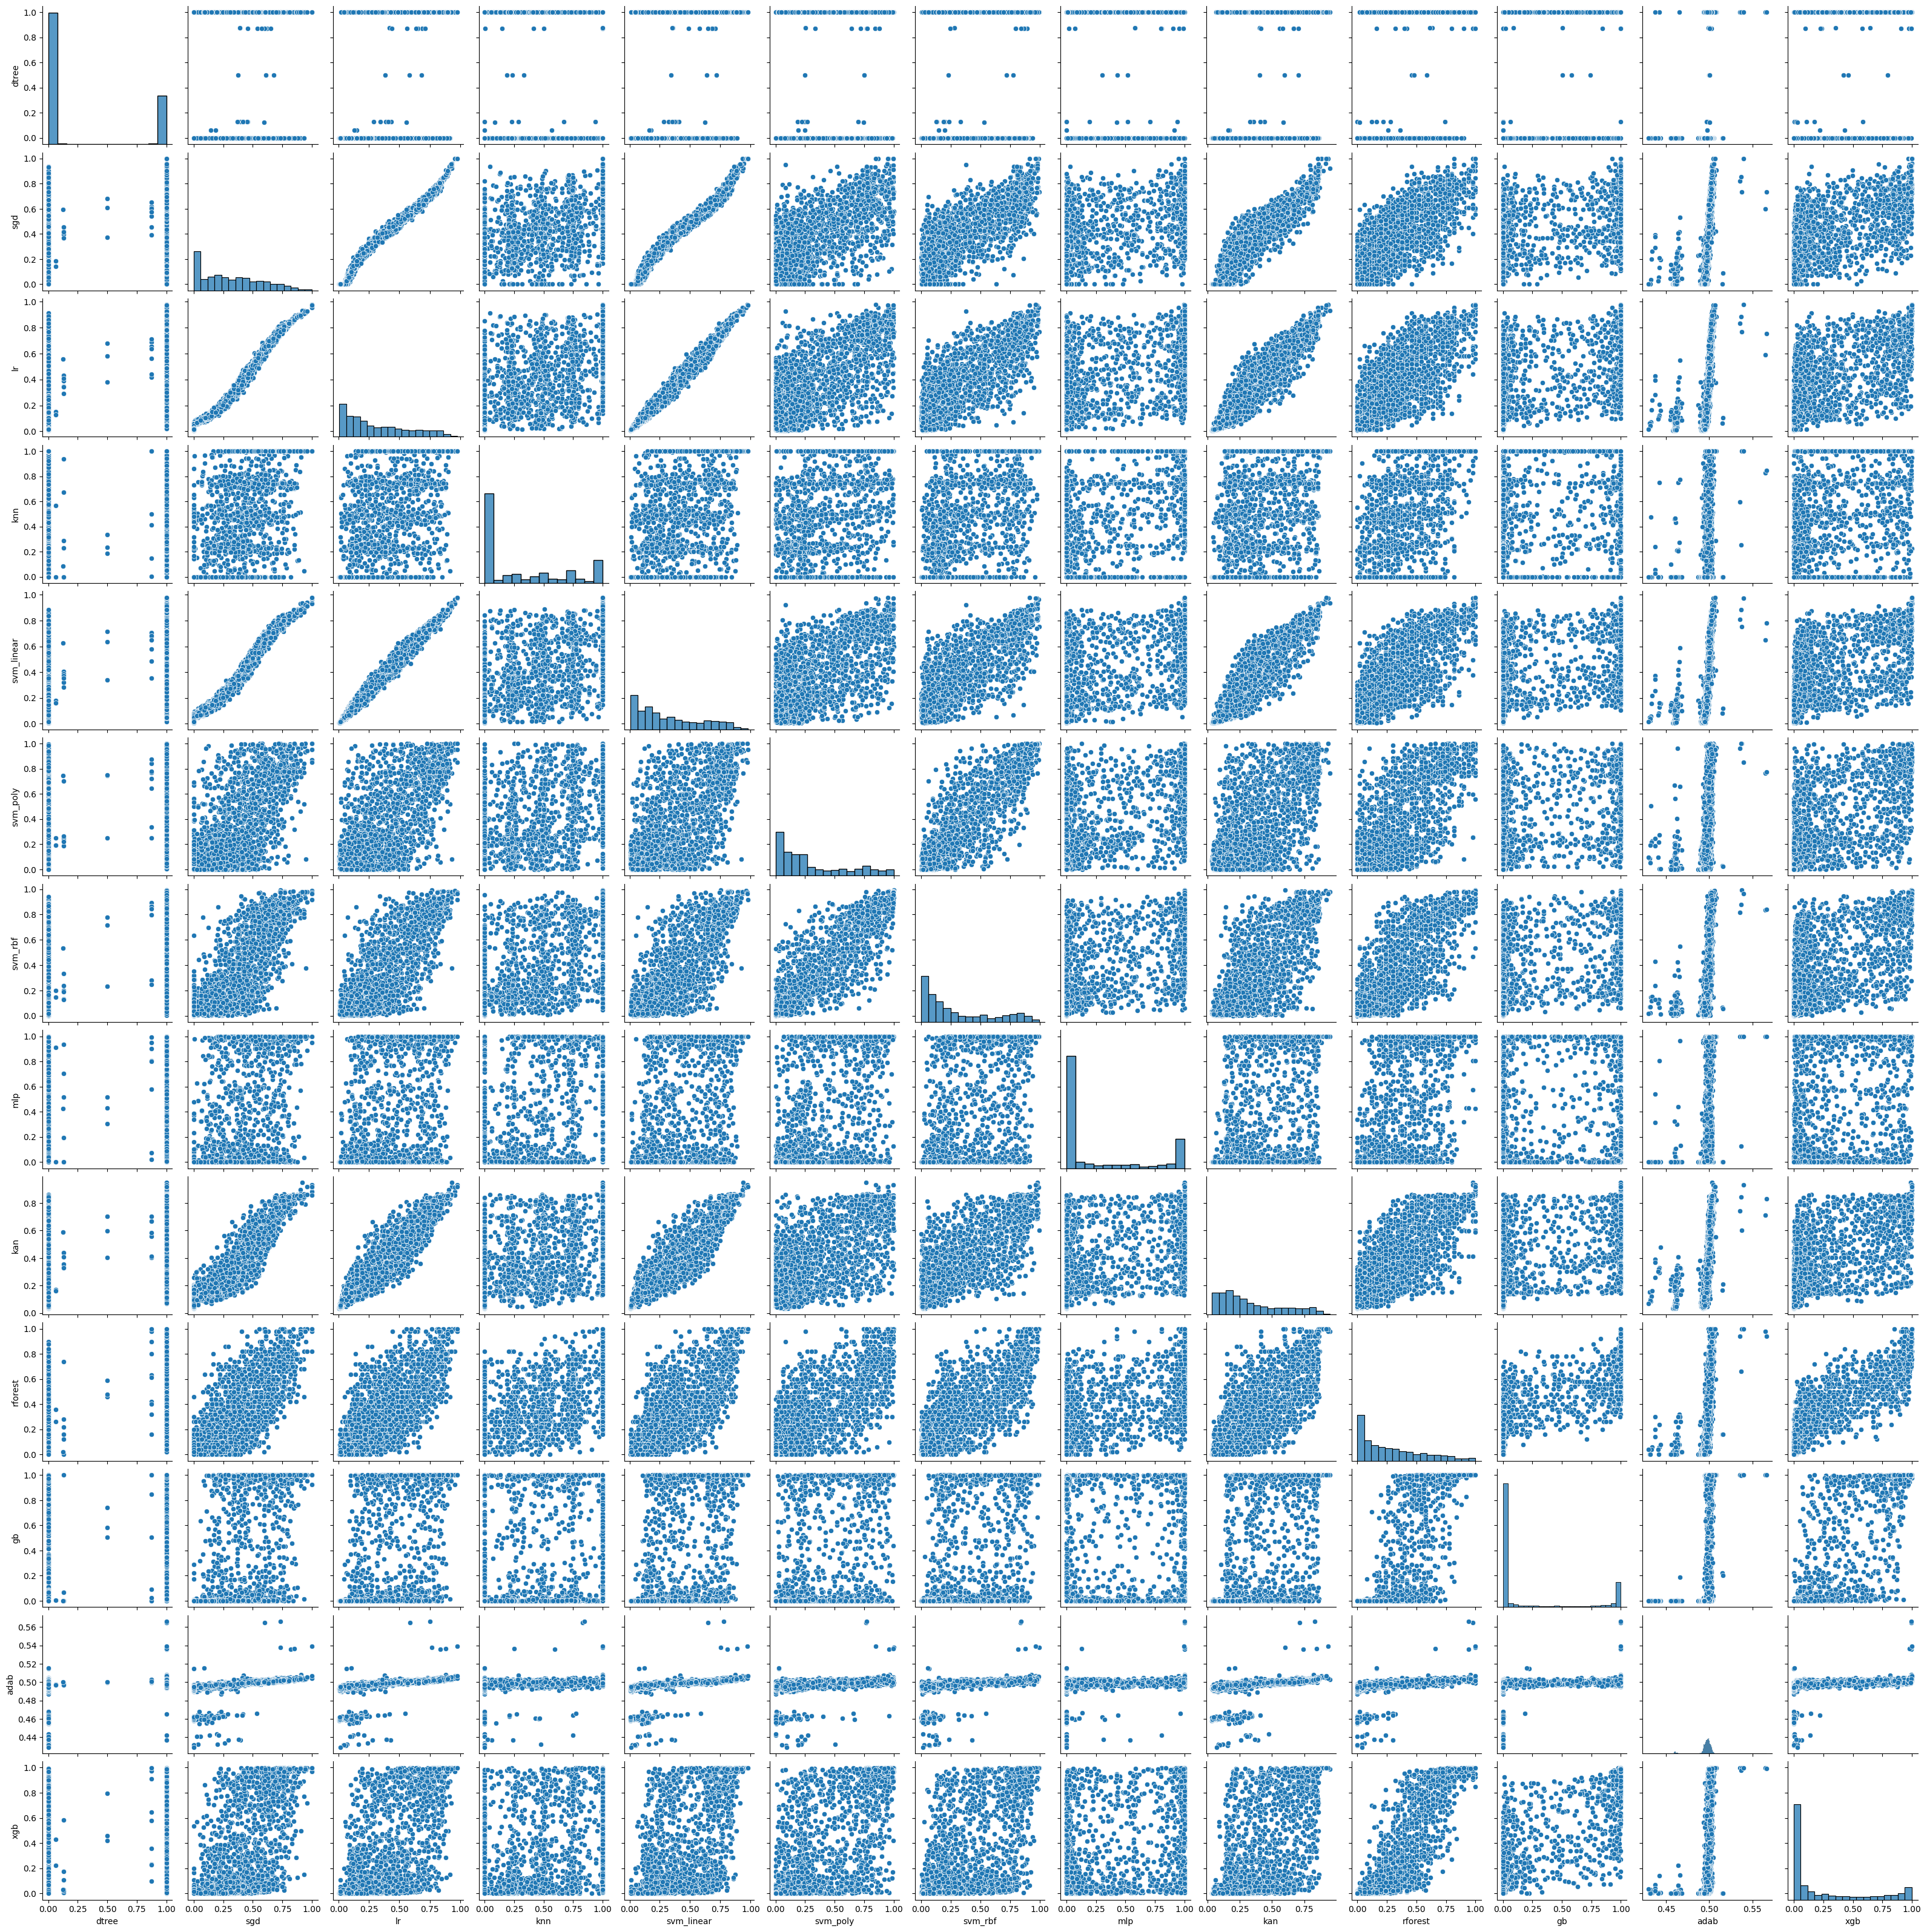

In [ ]:
sns.pairplot(models_error)

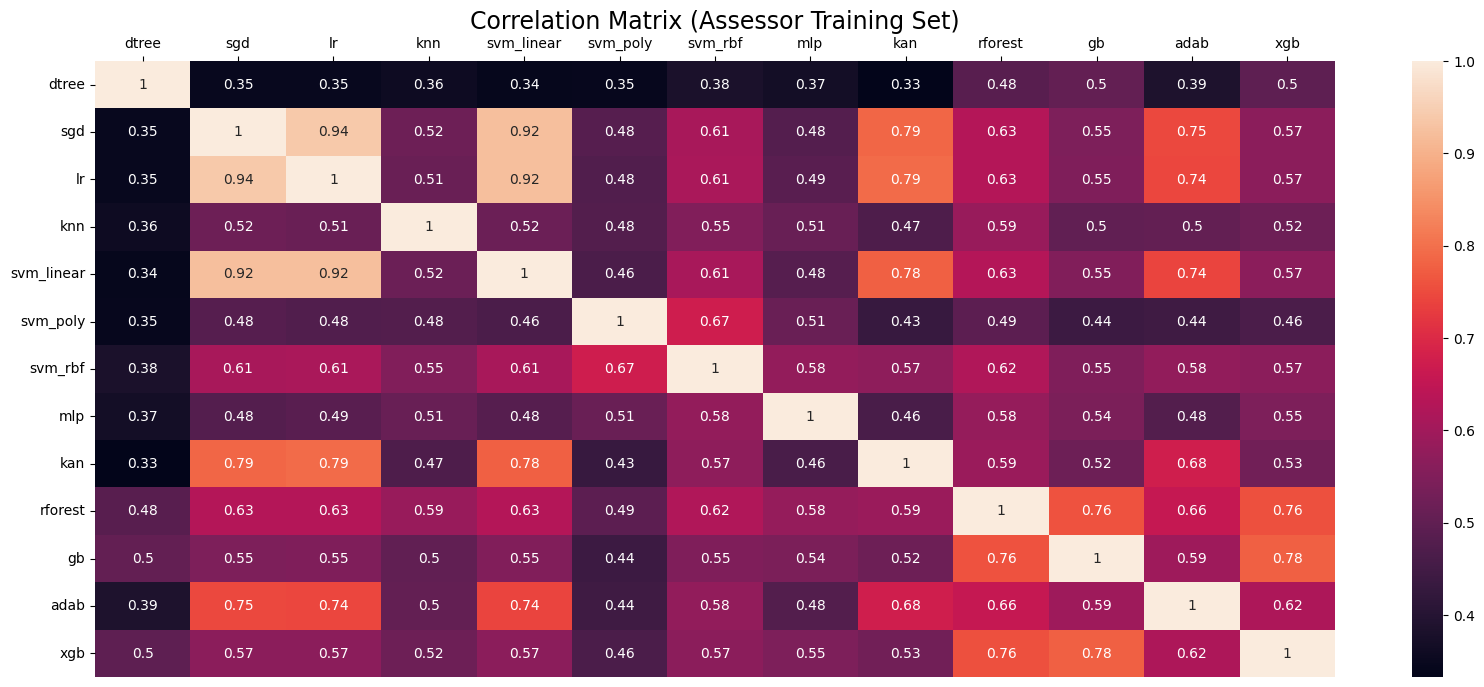

            corr
count  78.000000
mean    0.559824
std     0.134622
min     0.332737
25%     0.481144
50%     0.546214
75%     0.616927
max     0.938501


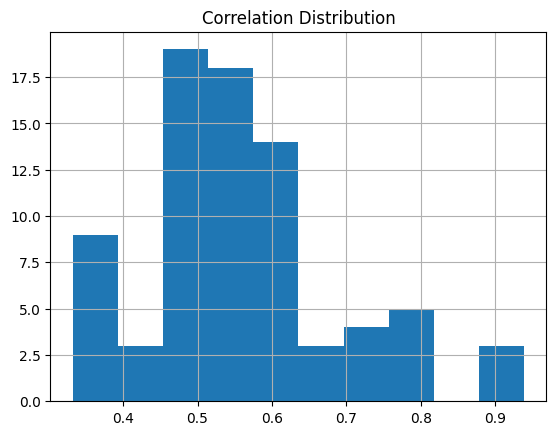

[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [191]:
pred_corrls = models_error.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Training Set)', fontsize=17)
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

plt.title('Correlation Distribution')
hg = corrls_values['corr'].hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [60]:
MIN_SCORE = 0.675 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.675


[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [61]:
Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0    1.0  0.816066  0.840734  1.000000    0.837717  0.907080  0.903634   
1    0.0  0.502942  0.506229  0.000000    0.569663  0.525230  0.544435   
2    1.0  0.568665  0.582332  1.000000    0.546538  0.876562  0.894867   
3    1.0  0.827625  0.859563  0.762667    0.852293  0.834433  0.888112   
4    0.0  0.490065  0.506757  0.000000    0.563256  0.182115  0.184304   

        mlp       kan  rforest        gb      adab       xgb  
0  0.710727  0.795878     0.42  0.784064  0.502135  0.542966  
1  0.000883  0.625491     0.32  0.005767  0.499038  0.601519  
2  1.000000  0.674331     0.88  0.999986  0.502213  0.997659  
3  0.989154  0.821220     0.78  0.840228  0.502755  0.811739  
4  0.000026  0.452406     0.14  0.000121  0.499719  0.011263

In [62]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0    0.0  0.141922  0.101620  0.000000    0.117275  0.134259  0.156307   
1    1.0  0.121427  0.111948  0.000000    0.128655  0.168696  0.185578   
2    1.0  0.823291  0.841404  1.000000    0.844831  0.999517  0.965199   
3    0.0  0.133640  0.124236  0.252403    0.161239  0.219065  0.171739   
4    0.0  0.216827  0.178295  0.000000    0.177934  0.168973  0.154507   

        mlp       kan  rforest        gb      adab       xgb  
0  0.883674  0.240909     0.02  0.000029  0.493983  0.006569  
1  0.363394  0.174968     0.34  0.981957  0.496981  0.472621  
2  0.987933  0.841956     0.92  0.999988  0.502688  0.977660  
3  0.000593  0.145484     0.08  0.004287  0.497029  0.034872  
4  0.000400  0.151761     0.00  0.000002  0.496568  0.010851

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

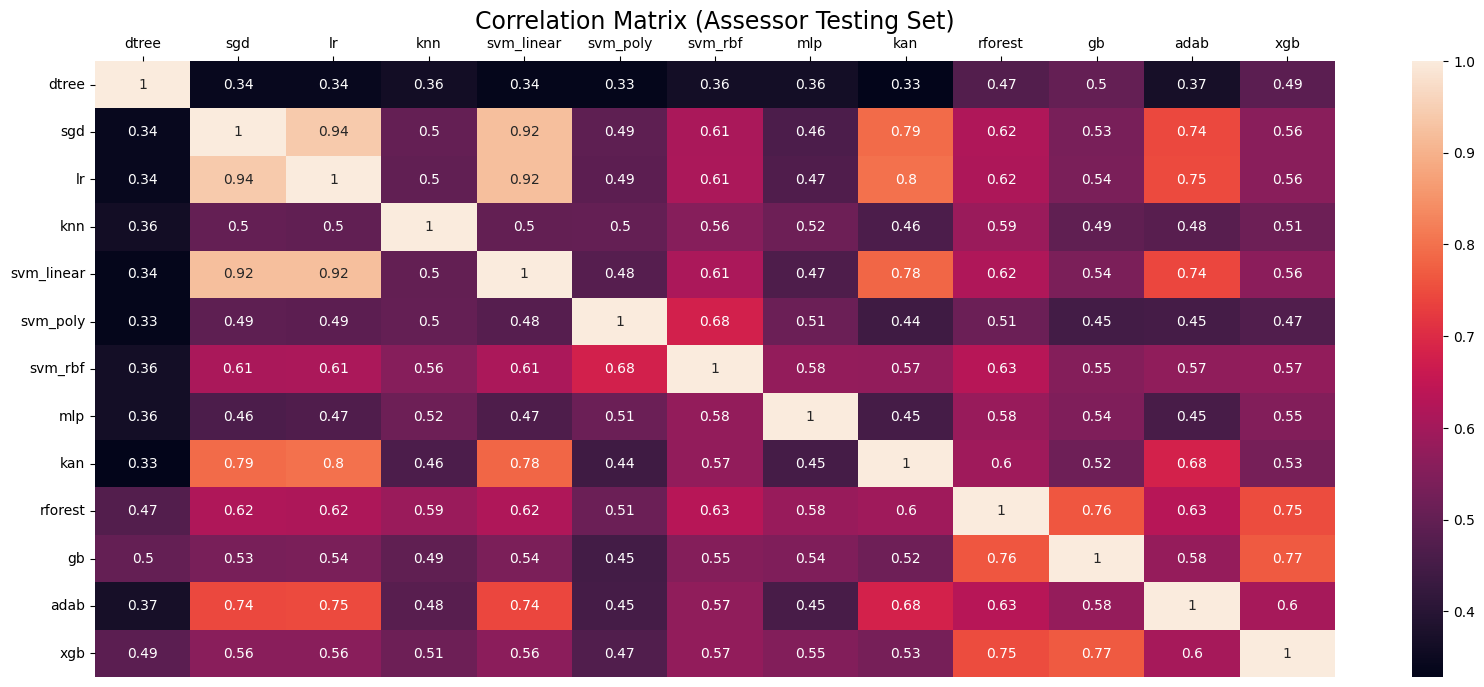

count    78.000000
mean      0.556942
std       0.136316
min       0.328257
25%       0.475346
50%       0.538026
75%       0.612333
max       0.940438
Name: corr, dtype: float64


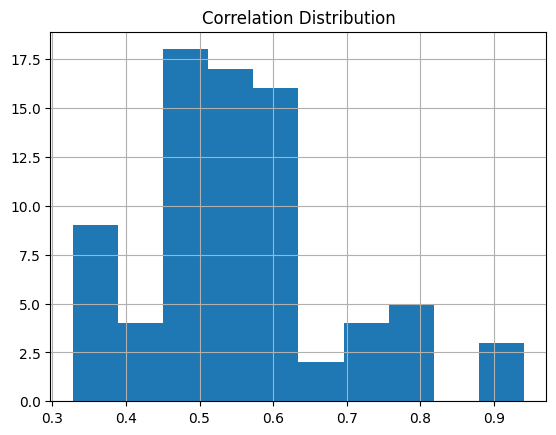

[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [192]:
pred_corrls2 = ya_test.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Testing Set)', fontsize=17)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

plt.title('Correlation Distribution')
hg = corrls_values2.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [64]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0001
NMSE: 0.0105
MAE: 0.0084
NMSE: 0.0061
Desvio Padrão: 0.0102


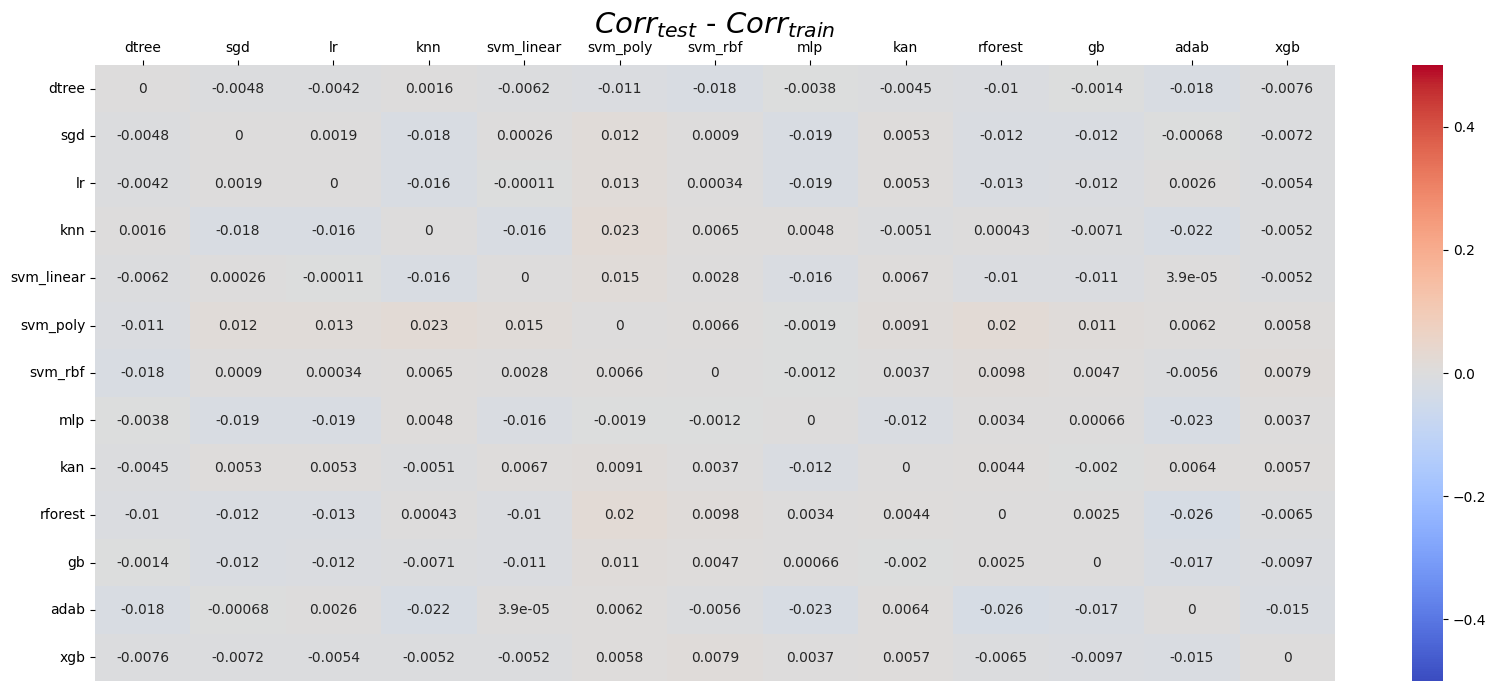

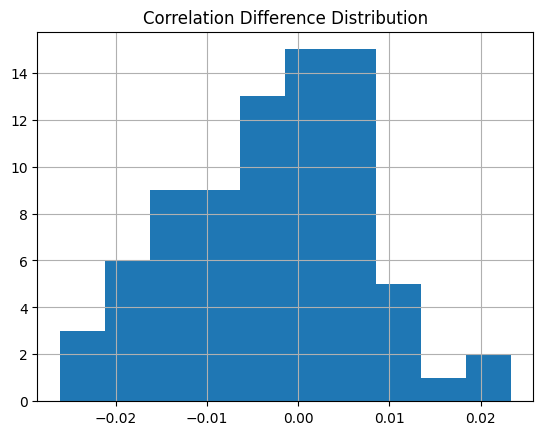

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [195]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

## Globais

### Regressor Chain
(RC)

In [66]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.6s
[Chain] .................. (2 of 13) Processing order 1, total=   0.9s
[Chain] .................. (3 of 13) Processing order 2, total=   1.1s
[Chain] .................. (4 of 13) Processing order 3, total=   1.1s
[Chain] .................. (5 of 13) Processing order 4, total=   1.5s
[Chain] .................. (6 of 13) Processing order 5, total=   1.6s
[Chain] .................. (7 of 13) Processing order 6, total=   1.8s
[Chain] .................. (8 of 13) Processing order 7, total=   2.1s
[Chain] .................. (9 of 13) Processing order 8, total=   2.1s
[Chain] ................. (10 of 13) Processing order 9, total=   2.2s
[Chain] ................ (11 of 13) Processing order 10, total=   2.7s
[Chain] ................ (12 of 13) Processing order 11, total=   3.4s
[Chain] ................ (13 of 13) Processing order 12, total=   2.8s


In [67]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [68]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0745
RMSE: 0.2526
MAE: 0.1878


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.178037  0.033546  0.041072  0.113431    0.038707  0.069492   
multi-output       NaN       NaN       NaN       NaN         NaN       NaN   
individual         NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.062493  0.133824  0.034532  0.046264  0.126845  0.000036   
multi-output       NaN       NaN       NaN       NaN       NaN       NaN   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.090028  
multi-output       NaN  
individual         NaN

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

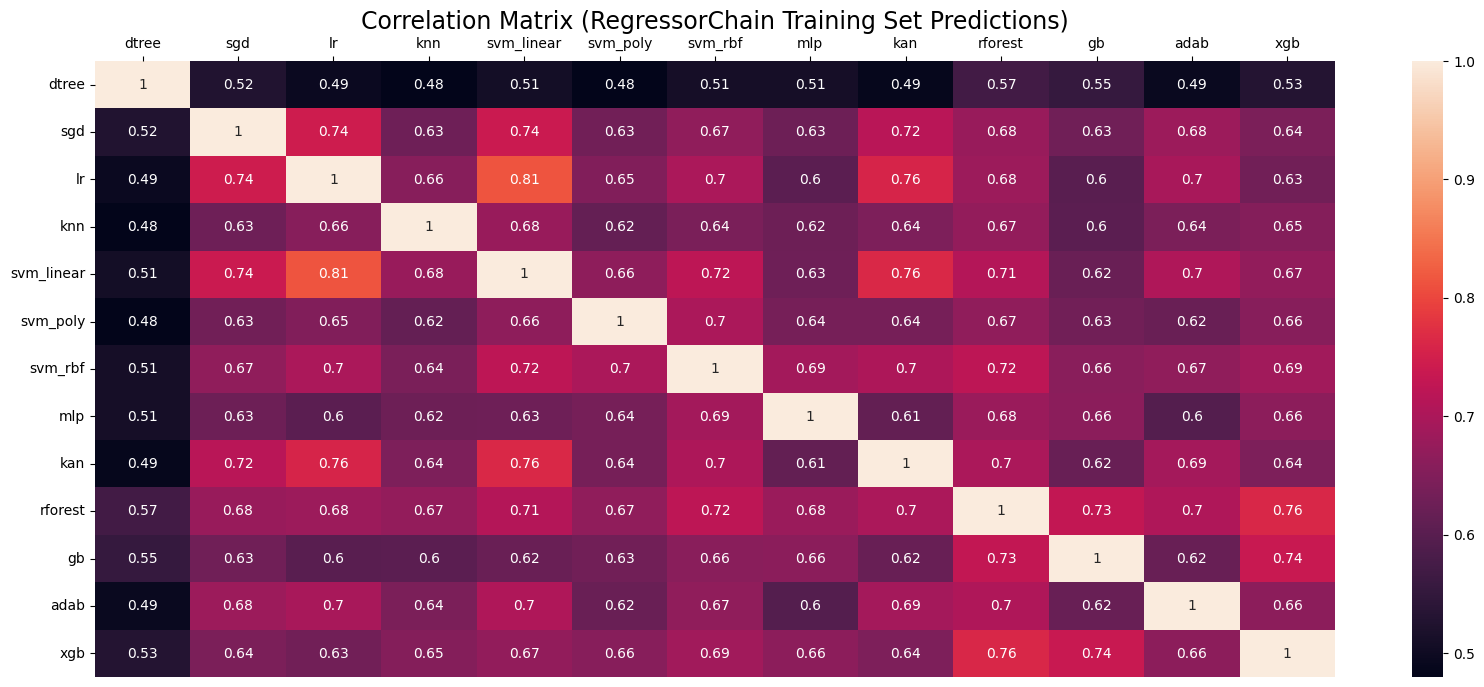

count    78.000000
mean      0.645249
std       0.072189
min       0.479636
25%       0.619848
50%       0.654792
75%       0.691579
max       0.813959
Name: corr, dtype: float64


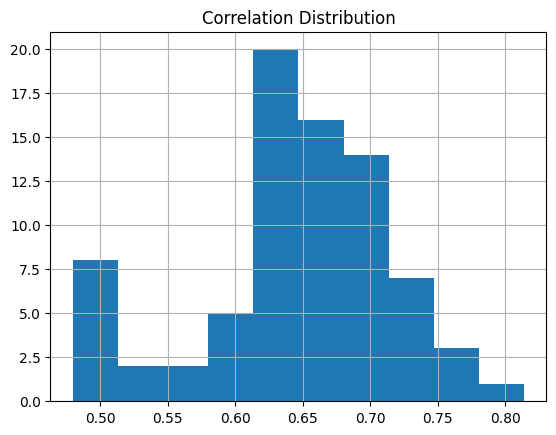

[Saved image "cm_rctrain.eps"]
[Saved image "cd_rctrain.eps"]


In [196]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('kendall') 

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Training Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [70]:
groups['regchain_assessor_train'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_train']

[['dtree'],
 ['adab', 'kan', 'lr', 'rforest', 'sgd', 'svm_linear'],
 ['kan', 'lr', 'rforest', 'svm_linear', 'svm_rbf'],
 ['knn', 'svm_linear'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'rforest', 'svm_rbf'],
 ['rforest', 'svm_rbf', 'xgb'],
 ['gb', 'rforest', 'xgb']]

Conjunto de Teste:

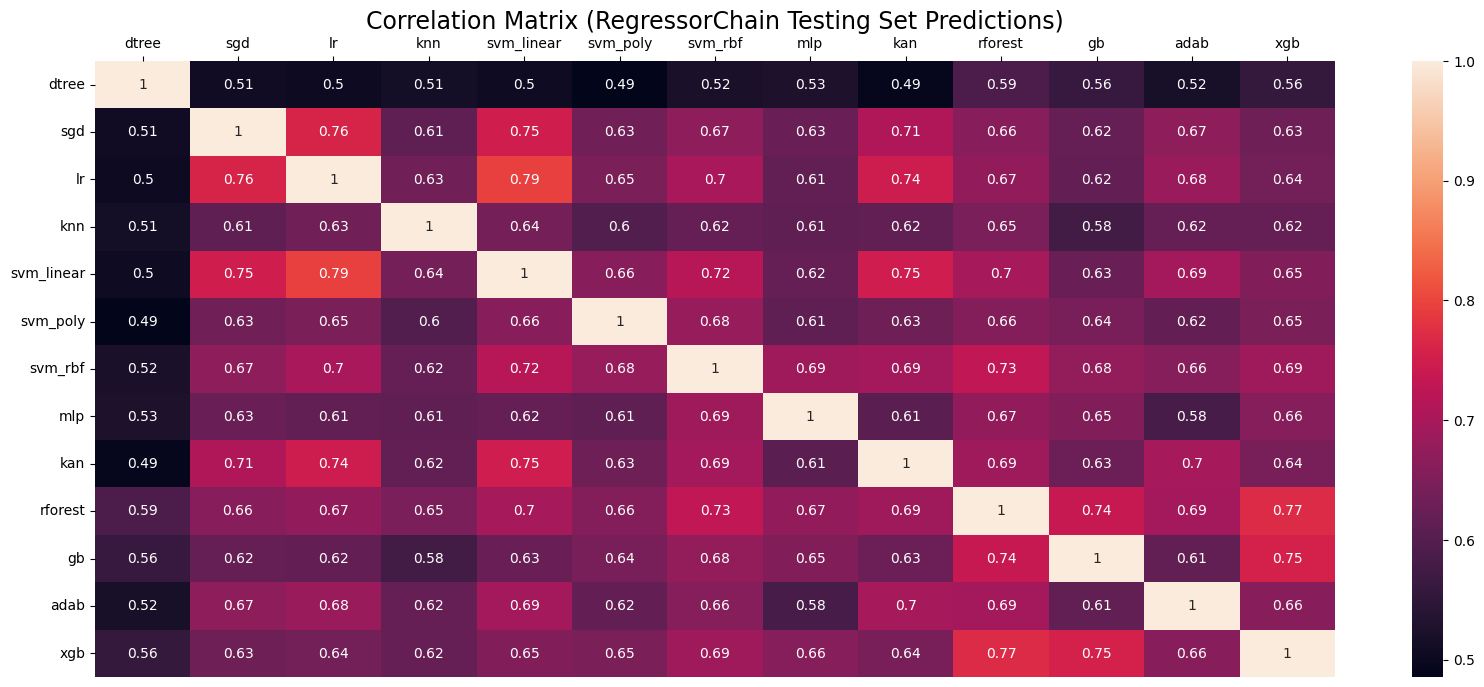

count    78.000000
mean      0.641302
std       0.068466
min       0.485543
25%       0.614657
50%       0.642901
75%       0.685908
max       0.794585
Name: corr, dtype: float64


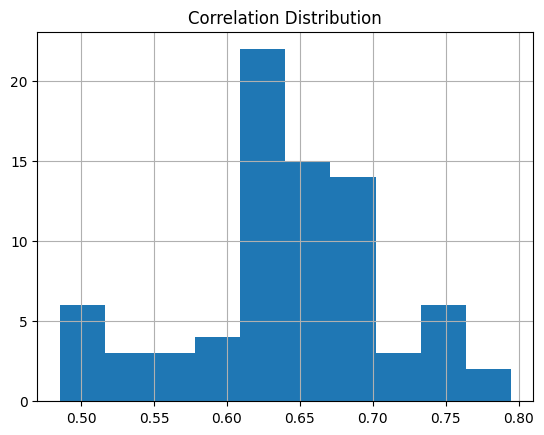

[Saved image "cm_rctest.eps"]
[Saved image "cd_rctest.eps"]


In [197]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [72]:
groups['regchain_assessor_test'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_test']

[['dtree'],
 ['kan', 'lr', 'sgd', 'svm_linear'],
 ['kan', 'lr', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'svm_linear'],
 ['knn'],
 ['kan', 'rforest', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'rforest', 'svm_linear'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'svm_rbf'],
 ['gb', 'rforest', 'svm_rbf', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0137
RMSE: 0.1170
MAE: 0.1070
NMSE: 0.7366
Desvio Padrão: 0.0816


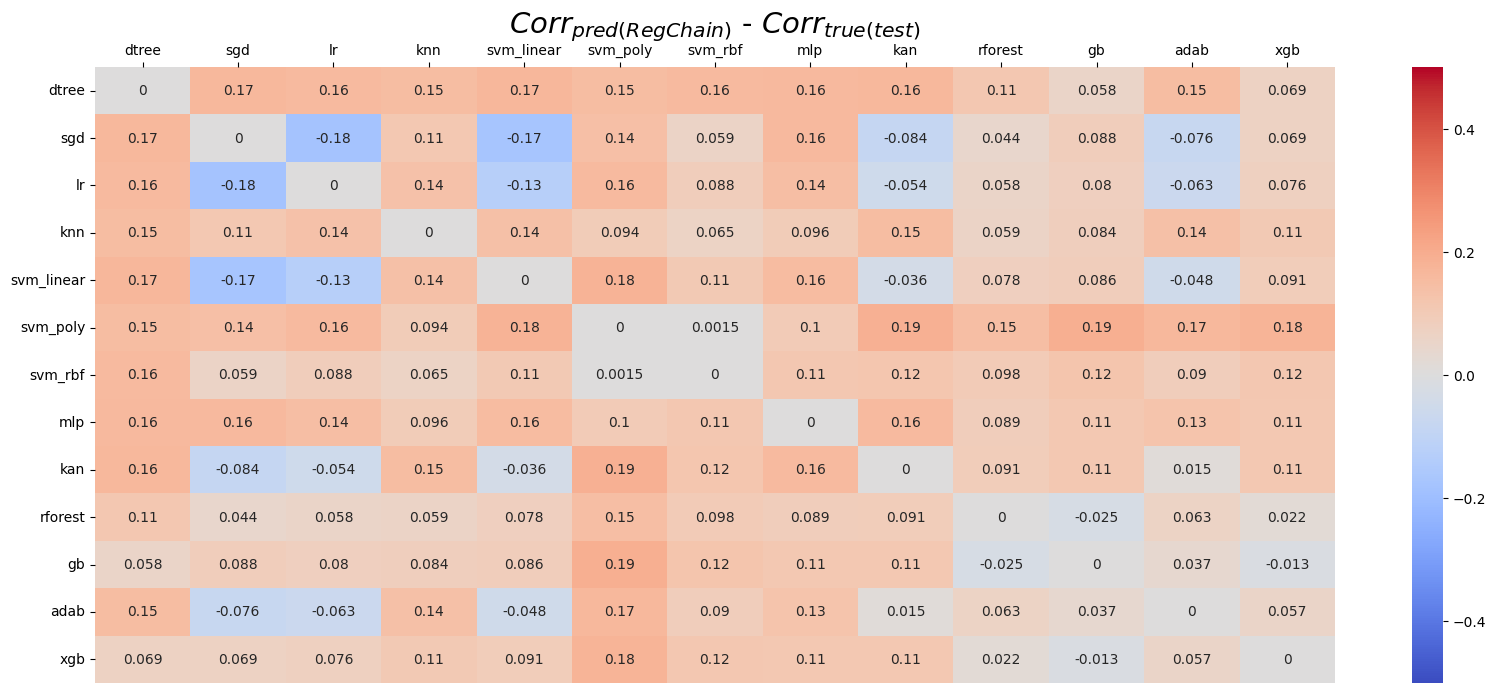

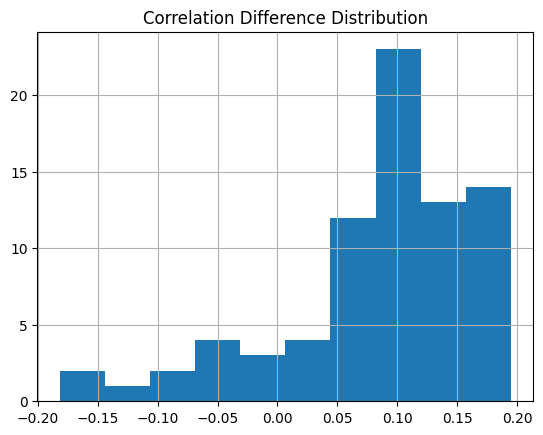

[Saved image "cmd_rc.eps"]
[Saved image "cd_rc.eps"]


In [198]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChain)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

### Multi-Output Regressor 
(ST)

In [74]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [75]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0757
RMSE: 0.2547
MAE: 0.1841


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.178037  0.033546  0.041072  0.113431    0.038707  0.069492   
multi-output  0.178037  0.034438  0.040257  0.116835    0.039294  0.071065   
individual         NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.062493  0.133824  0.034532  0.046264  0.126845  0.000036   
multi-output  0.063629  0.137116  0.035089  0.048856  0.127702  0.000036   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.090028  
multi-output  0.091512  
individual         NaN

#### Análise das correlações

Conjunto de Treinamento:

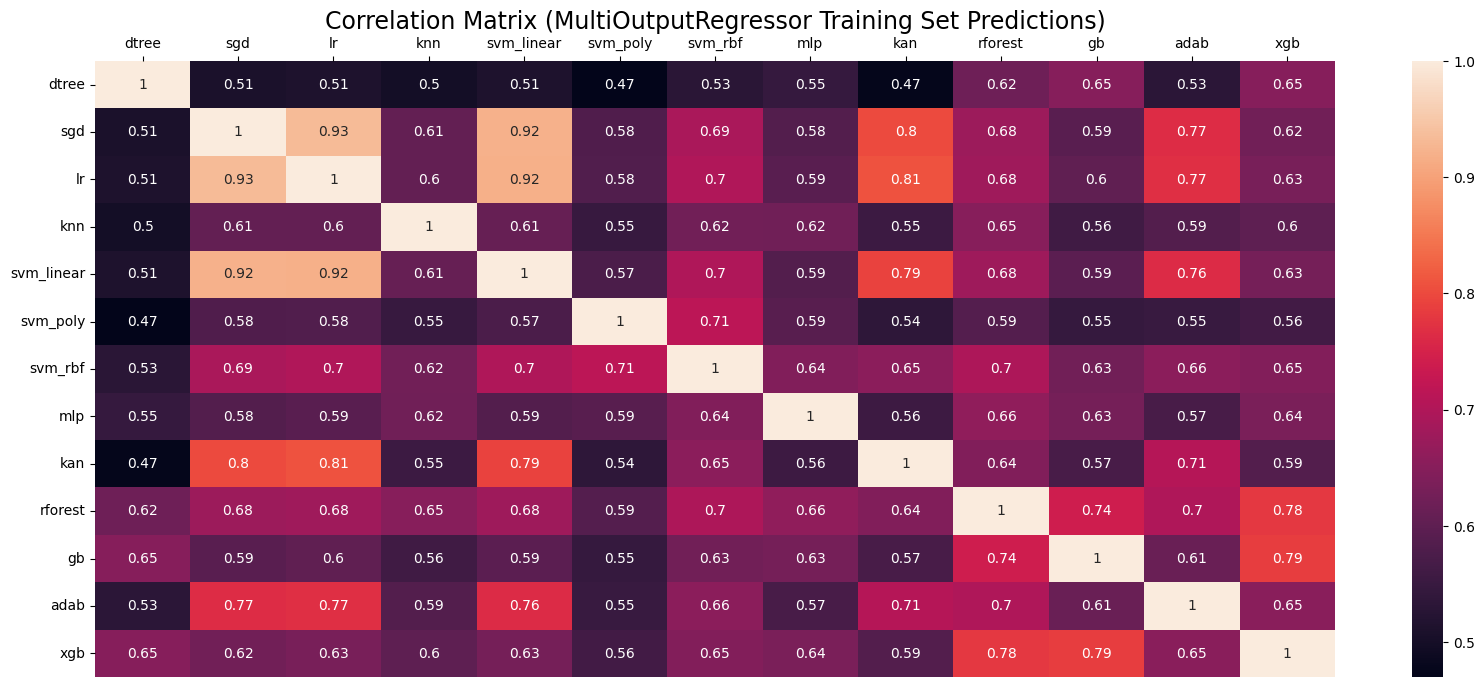

count    78.000000
mean      0.636948
std       0.097030
min       0.470079
25%       0.575778
50%       0.623564
75%       0.679801
max       0.933086
Name: corr, dtype: float64


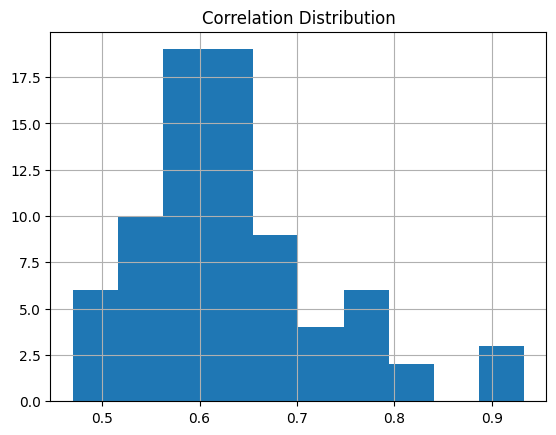

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [199]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [77]:
groups['mor_assessor_train'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_train']

[['dtree'],
 ['lr', 'rforest', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['adab', 'lr', 'rforest', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

Conjunto de Teste:

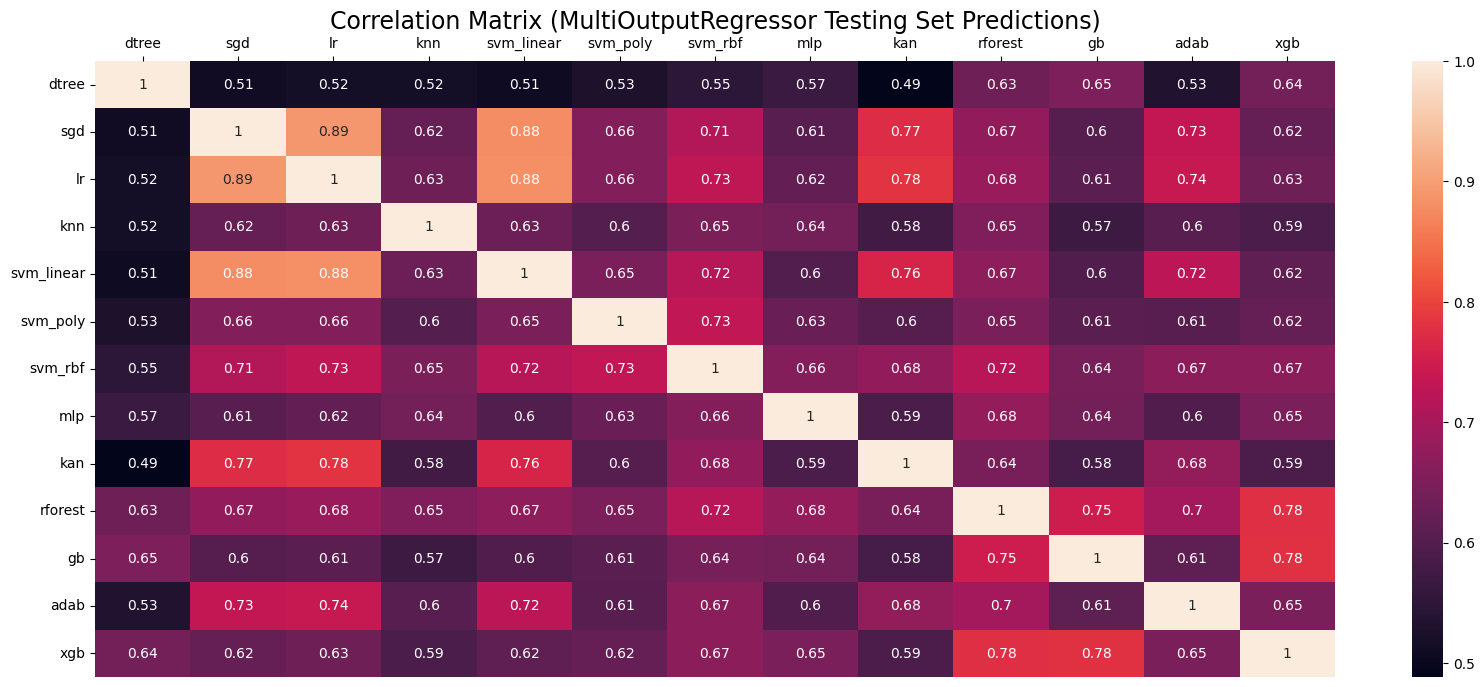

count    78.000000
mean      0.649017
std       0.081683
min       0.488549
25%       0.602560
50%       0.639660
75%       0.678956
max       0.891127
Name: corr, dtype: float64


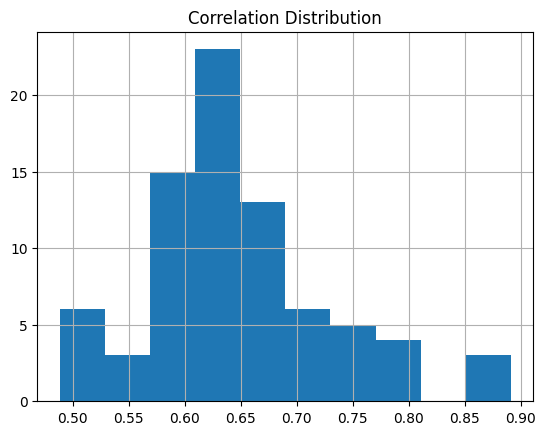

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [200]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [79]:
groups['mor_assessor_test'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_test']

[['dtree'],
 ['kan', 'lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['lr', 'rforest', 'svm_rbf'],
 ['adab', 'lr', 'rforest'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp', 'rforest'],
 ['gb', 'rforest', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0124
RMSE: 0.1116
MAE: 0.0983
NMSE: 0.6700
Desvio Padrão: 0.0634


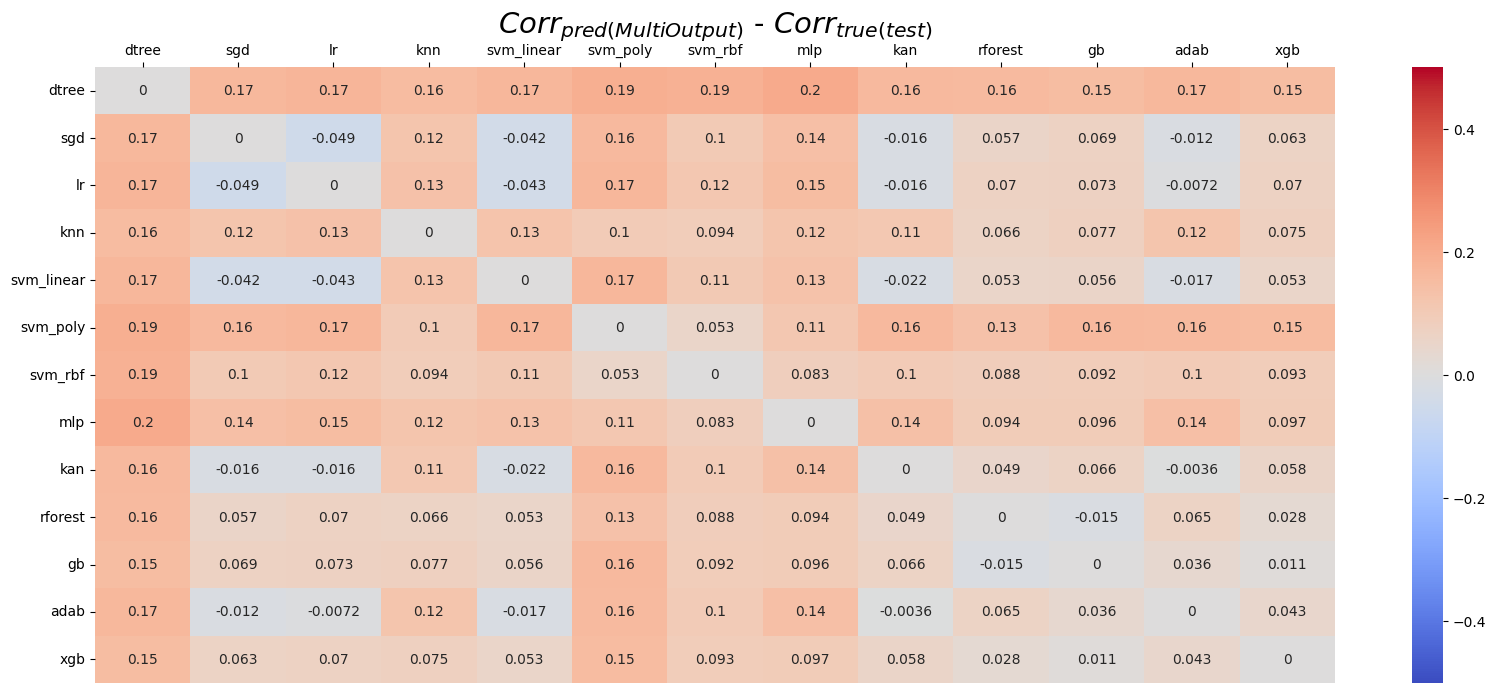

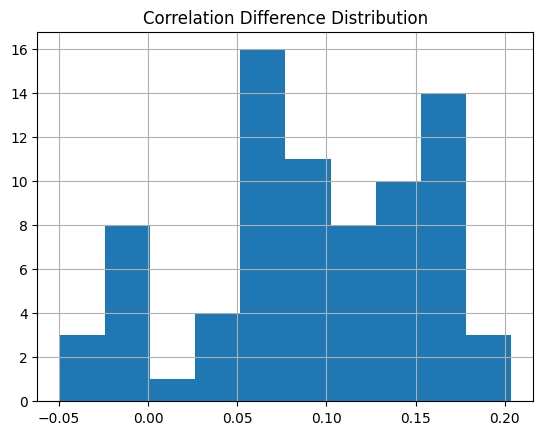

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [201]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutput)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

## Individuais

In [81]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.1264

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Score: 0.5322

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 50}
Score: 0.4624

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 50}
Score: 0.2254

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 20}
Score: 0.4836

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'poisson', 'max_depth': 10, 'min_samples_le

In [82]:
metrics_indv = {'MSE':[], 'RMSE':[], 'MAE':[], 'NMSE':[]}

for m in model_names:
    y_pred = ind_assessors[m].predict(Xa_test)

    # Cálculo das métricas
    metrics_indv['MSE'].append(mse(ya_test[m], y_pred))
    metrics_indv['RMSE'].append(rmse(ya_test[m], y_pred))
    metrics_indv['MAE'].append(mae(ya_test[m], y_pred))
    metrics_indv['NMSE'].append(nmse(ya_test[m], y_pred))


    mse_df.at['individual',m] = mse(ya_test[m], y_pred)
    rmse_df.at['individual',m] = rmse(ya_test[m], y_pred)
    mae_df.at['individual',m] = mae(ya_test[m], y_pred)
    nmse_df.at['individual',m] = nmse(ya_test[m], y_pred)

for k in metrics_indv.keys():
    print(f'''{k}:
    - Média: {np.mean(metrics_indv[k]):.4f}
    - DP:    {np.std(metrics_indv[k]):.4f}''')

mse_df

MSE:
    - Média: 0.0711
    - DP:    0.0468
RMSE:
    - Média: 0.2467
    - DP:    0.1012
MAE:
    - Média: 0.1830
    - DP:    0.0853
NMSE:
    - Média: 0.6598
    - DP:    0.1600


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.178037  0.033546  0.041072  0.113431    0.038707  0.069492   
multi-output  0.178037  0.034438  0.040257  0.116835    0.039294  0.071065   
individual    0.172037  0.032433  0.037761  0.108768    0.036211  0.066569   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.062493  0.133824  0.034532  0.046264  0.126845  0.000036   
multi-output  0.063629  0.137116  0.035089  0.048856  0.127702  0.000036   
individual    0.059422  0.126066  0.033023  0.045570  0.121058  0.000033   

                   xgb  
regchain      0.090028  
multi-output  0.091512  
individual    0.085556

#### Análise das correlações

Conjunto de Treinamento:

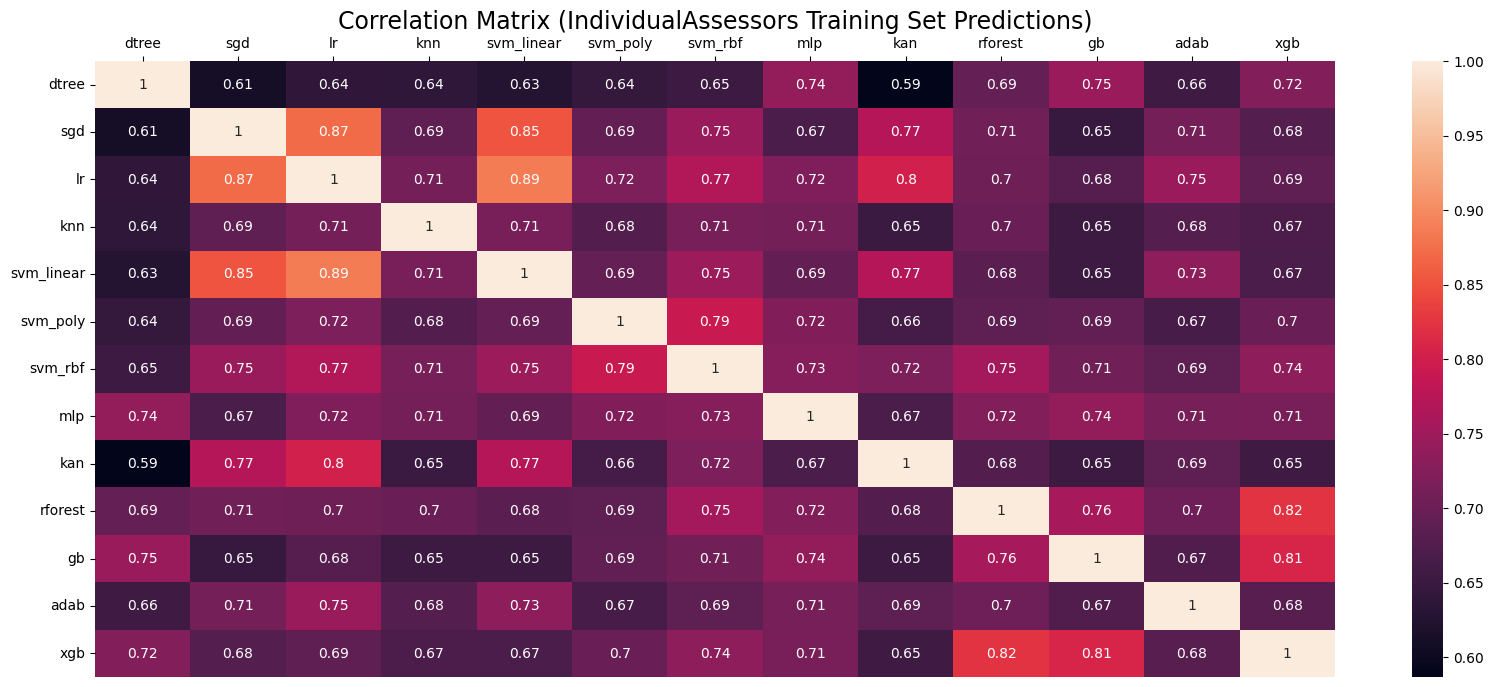

count    78.000000
mean      0.706836
std       0.055220
min       0.586704
25%       0.670767
50%       0.699358
75%       0.732147
max       0.885830
Name: corr, dtype: float64


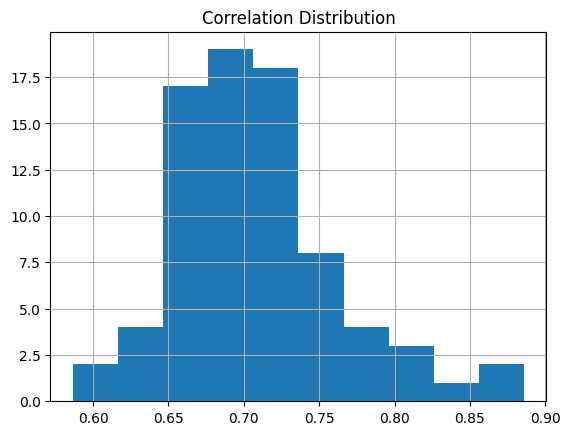

[Saved image "cm_iatrain.eps"]
[Saved image "cd_iatrain.eps"]


In [202]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_train.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_train)

indass_corrls = indass_corrls.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (IndividualAssessors Training Set Predictions)', fontsize=17)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

indass_corrls_values = corrlArray(indass_corrls)['corr']
print(indass_corrls_values.describe())

plt.title('Correlation Distribution')
hg = indass_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [84]:
groups['indv_assessor_train'] = group_search(indass_corrls, MIN_SCORE)
groups['indv_assessor_train']

[['dtree', 'gb', 'mlp', 'rforest', 'xgb'],
 ['knn', 'lr', 'rforest', 'sgd', 'svm_linear', 'svm_poly', 'svm_rbf'],
 ['adab', 'knn', 'lr', 'rforest', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'rforest', 'sgd', 'svm_linear', 'svm_rbf'],
 ['lr', 'rforest', 'sgd', 'svm_poly', 'svm_rbf', 'xgb'],
 ['adab', 'lr', 'rforest', 'sgd', 'svm_rbf', 'xgb'],
 ['knn', 'lr', 'mlp', 'rforest', 'svm_linear', 'svm_poly', 'svm_rbf'],
 ['adab', 'knn', 'lr', 'mlp', 'rforest', 'svm_linear', 'svm_rbf'],
 ['gb', 'lr', 'mlp', 'rforest', 'svm_poly', 'svm_rbf', 'xgb'],
 ['adab', 'lr', 'mlp', 'rforest', 'svm_rbf', 'xgb']]

Conjunto de Teste:

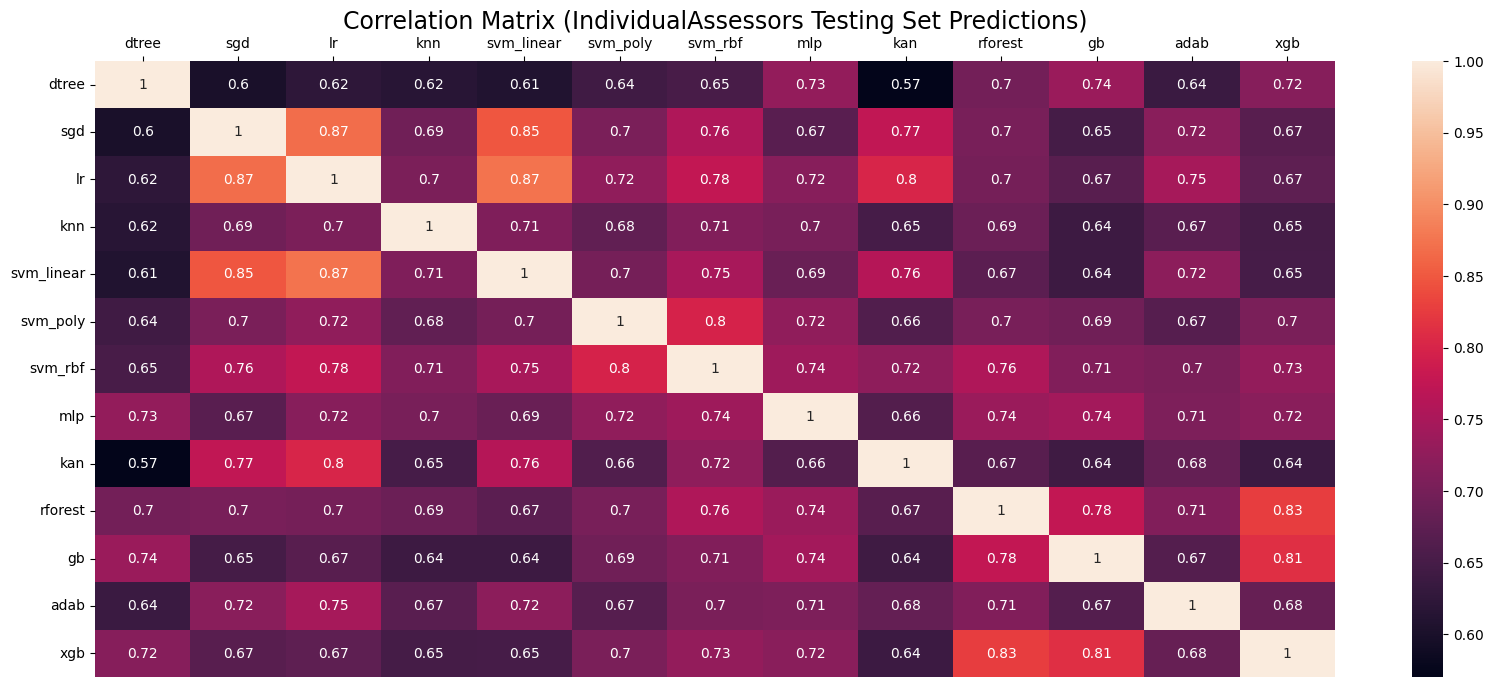

count    78.000000
mean      0.704224
std       0.058772
min       0.570094
25%       0.667130
50%       0.702425
75%       0.729277
max       0.872674
Name: corr, dtype: float64


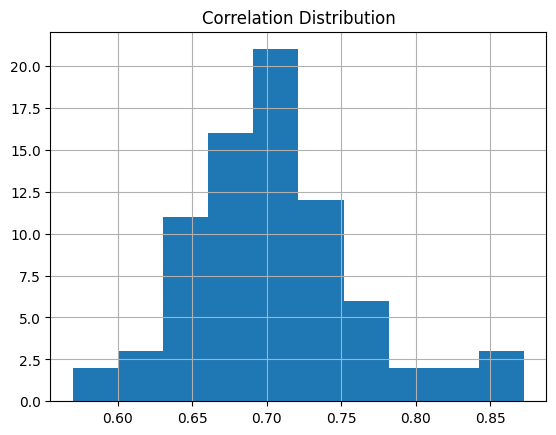

[Saved image "cm_iatest.eps"]
[Saved image "cd_iatest.eps"]


In [203]:
indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_test.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_test)

indass_corrls = indass_corrls.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (IndividualAssessors Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

indass_corrls_values = corrlArray(indass_corrls)['corr']
print(indass_corrls_values.describe())

plt.title('Correlation Distribution')
hg = indass_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

In [86]:
groups['indv_assessor_test'] = group_search(indass_corrls, MIN_SCORE)
groups['indv_assessor_test']

[['dtree', 'gb', 'mlp', 'rforest', 'xgb'],
 ['knn', 'lr', 'sgd', 'svm_linear', 'svm_poly', 'svm_rbf'],
 ['knn', 'lr', 'rforest', 'sgd', 'svm_poly', 'svm_rbf'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['adab', 'lr', 'rforest', 'sgd', 'svm_rbf'],
 ['knn', 'lr', 'mlp', 'svm_linear', 'svm_poly', 'svm_rbf'],
 ['knn', 'lr', 'mlp', 'rforest', 'svm_poly', 'svm_rbf'],
 ['adab', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['adab', 'lr', 'mlp', 'rforest', 'svm_rbf'],
 ['gb', 'mlp', 'rforest', 'svm_poly', 'svm_rbf', 'xgb'],
 ['adab', 'mlp', 'rforest', 'svm_rbf', 'xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0306
RMSE: 0.1750
MAE: 0.1545
NMSE: 1.6482
Desvio Padrão: 0.0951


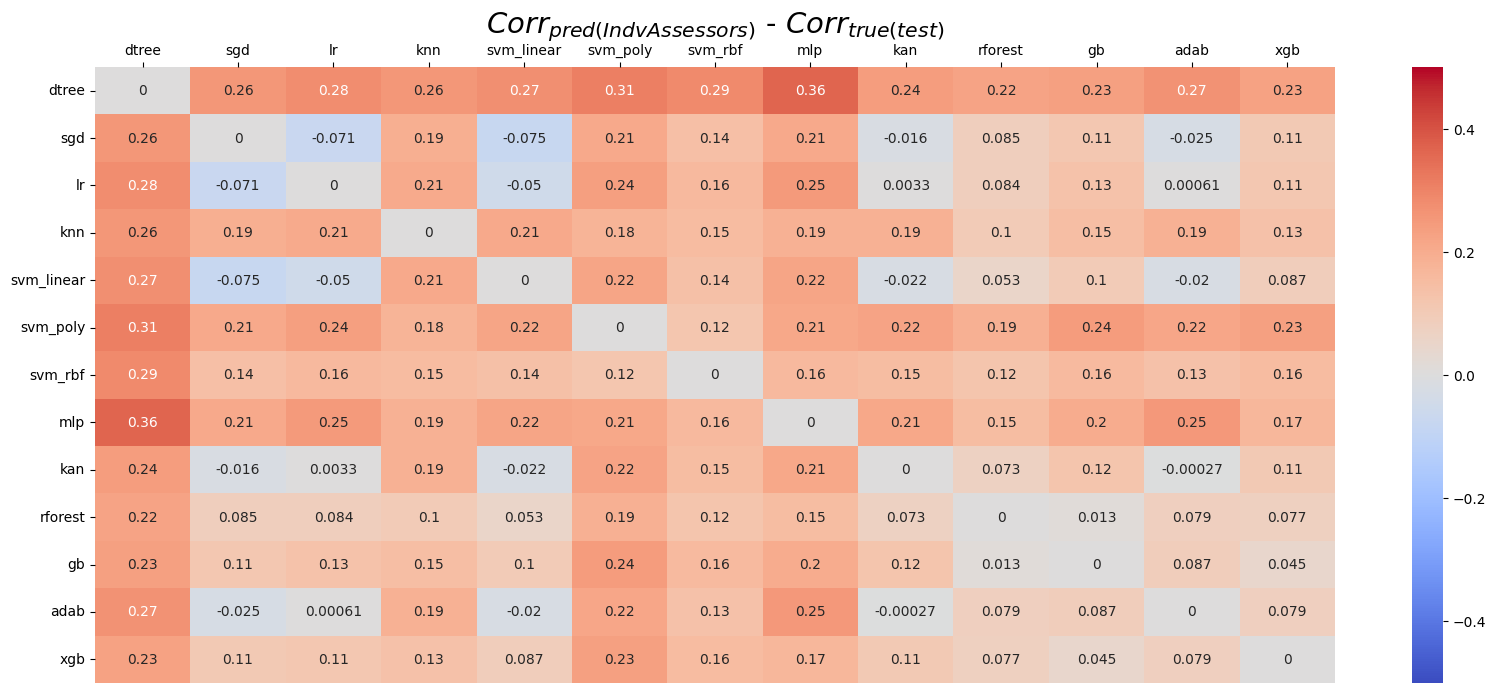

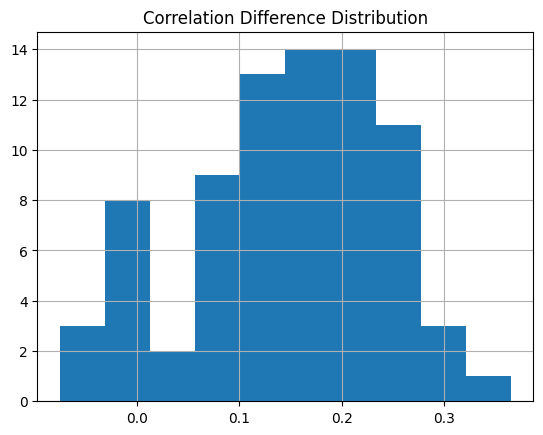

[Saved image "cmd_ia.eps"]
[Saved image "cdd_ia.eps"]


In [205]:
#pred_corrls2 = ya_test.corr('kendall')
diff_corrls = indass_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
RMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(IndvAssessors)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, 'churn')

## Grupais

In [88]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(7) & true_assessor_test(6):
['dtree']
['adab', 'kan', 'lr', 'sgd', 'svm_linear']
['knn']
['mlp']
['gb', 'rforest', 'xgb']
Número de grupos em comum: 5


true_assessor_train(7) & regchain_assessor_train(8):
['dtree']
['gb', 'rforest', 'xgb']
Número de grupos em comum: 2


true_assessor_train(7) & regchain_assessor_test(10):
['dtree']
['knn']
Número de grupos em comum: 2


true_assessor_train(7) & mor_assessor_train(8):
['dtree']
['adab', 'kan', 'lr', 'sgd', 'svm_linear']
['knn']
['mlp']
['gb', 'rforest', 'xgb']
Número de grupos em comum: 5


true_assessor_train(7) & mor_assessor_test(9):
['dtree']
['adab', 'kan', 'lr', 'sgd', 'svm_linear']
['knn']
['gb', 'rforest', 'xgb']
Número de grupos em comum: 4


true_assessor_train(7) & indv_assessor_train(10):
Número de grupos em comum: 0


true_assessor_train(7) & indv_assessor_test(11):
Número de grupos em comum: 0


true_assessor_test(6) & regchain_assessor_train(8):
['dtree']
['svm_poly', 'svm_rbf']
['gb', 'rforest', 'xgb

In [89]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['adab', 'kan', 'lr', 'sgd', 'svm_linear']
total: 0.8045154289056672

['gb', 'rforest', 'xgb']
total: 0.764215204507198



In [90]:
groups['true_assessor_train']

[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly'],
 ['svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

In [91]:
groups['true_assessor_test']

[['dtree'],
 ['adab', 'kan', 'lr', 'sgd', 'svm_linear'],
 ['knn'],
 ['svm_poly', 'svm_rbf'],
 ['mlp'],
 ['gb', 'rforest', 'xgb']]

### Regressor Chain

In [92]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [93]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0757
RMSE: 0.2547
MAE: 0.1841
NMSE: 0.7044


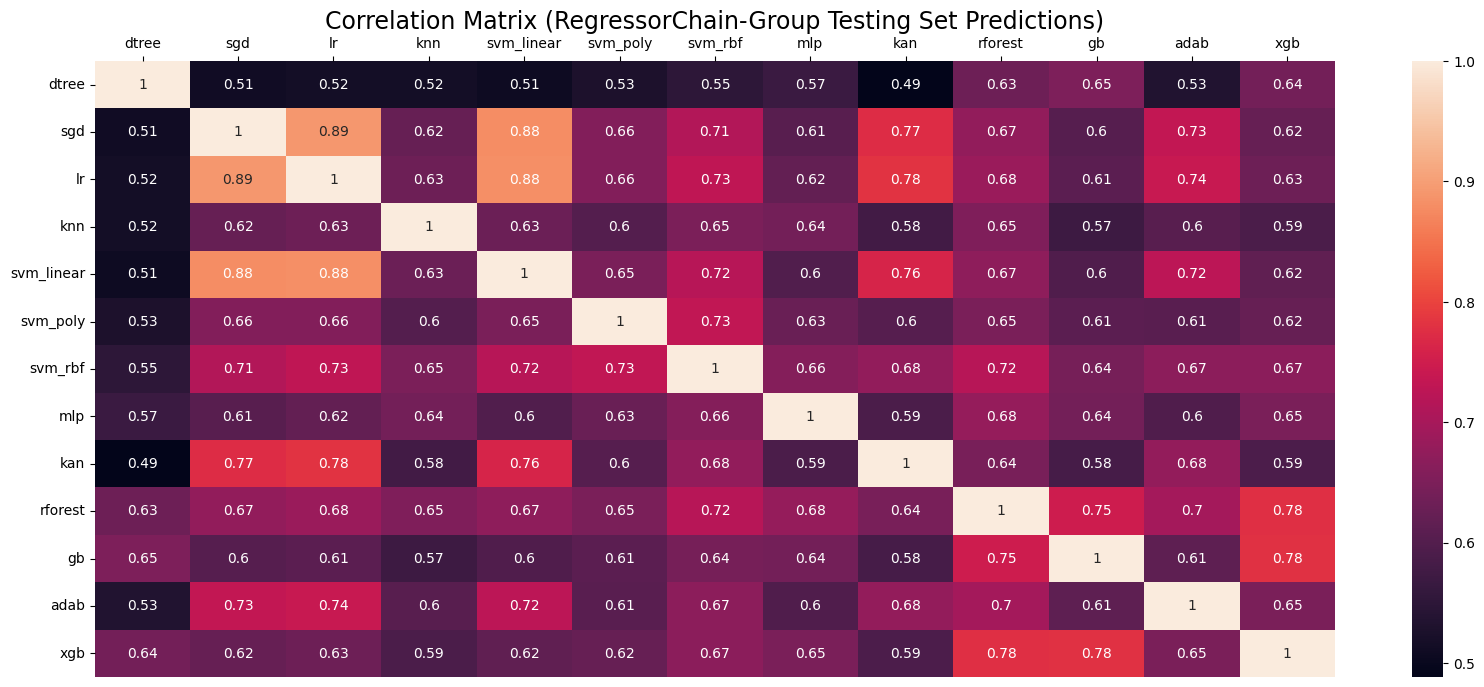

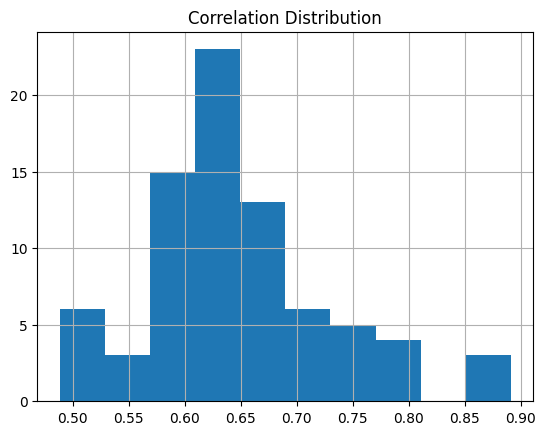

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0124
NMSE: 0.1116
MAE: 0.0983
NMSE: 0.6700
Desvio Padrão: 0.0634


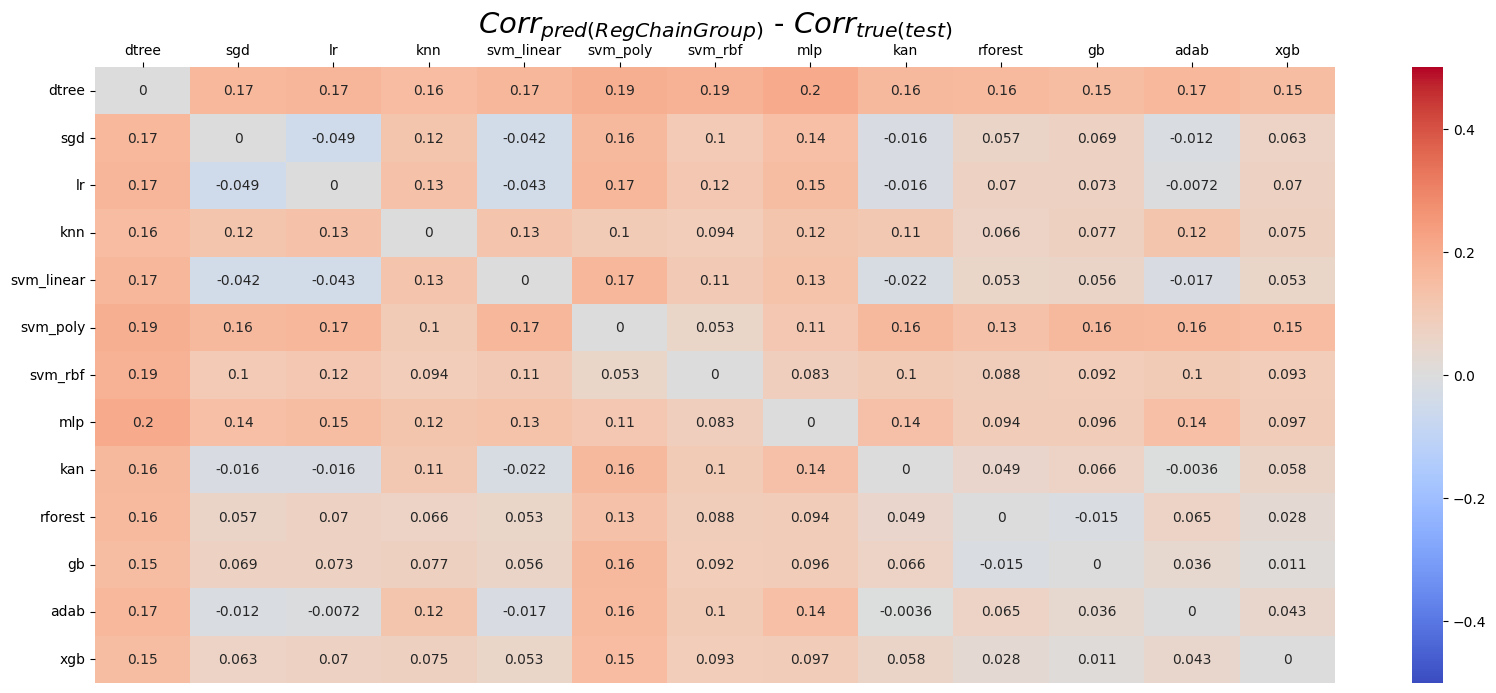

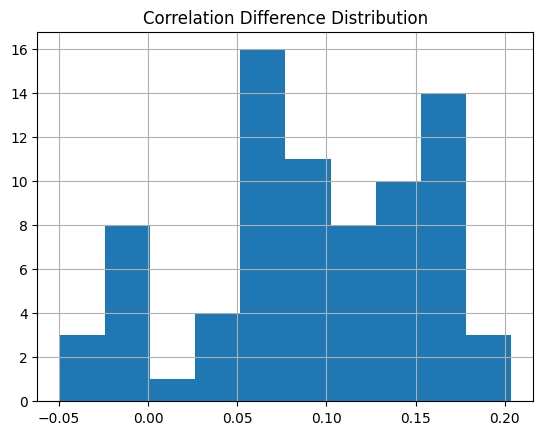

[Saved image "cm_rcgtest.eps"]
[Saved image "cd_rcgtest.eps"]
[Saved image "cmd_rcg.eps"]
[Saved image "cdd_rcg.eps"]


In [206]:
regchainGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(regchainGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(regchainGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChainGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

save2figs(hm1, hg1, 'churn')
save2figs(hm2, hg2, 'churn')

### Multi-Output Regressor

In [95]:
mor4groups = []

for g in groups['true_assessor_train']:
    model = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train[g])
    mor4groups.append(model)

In [96]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mor4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0757
RMSE: 0.2547
MAE: 0.1841
NMSE: 0.7044


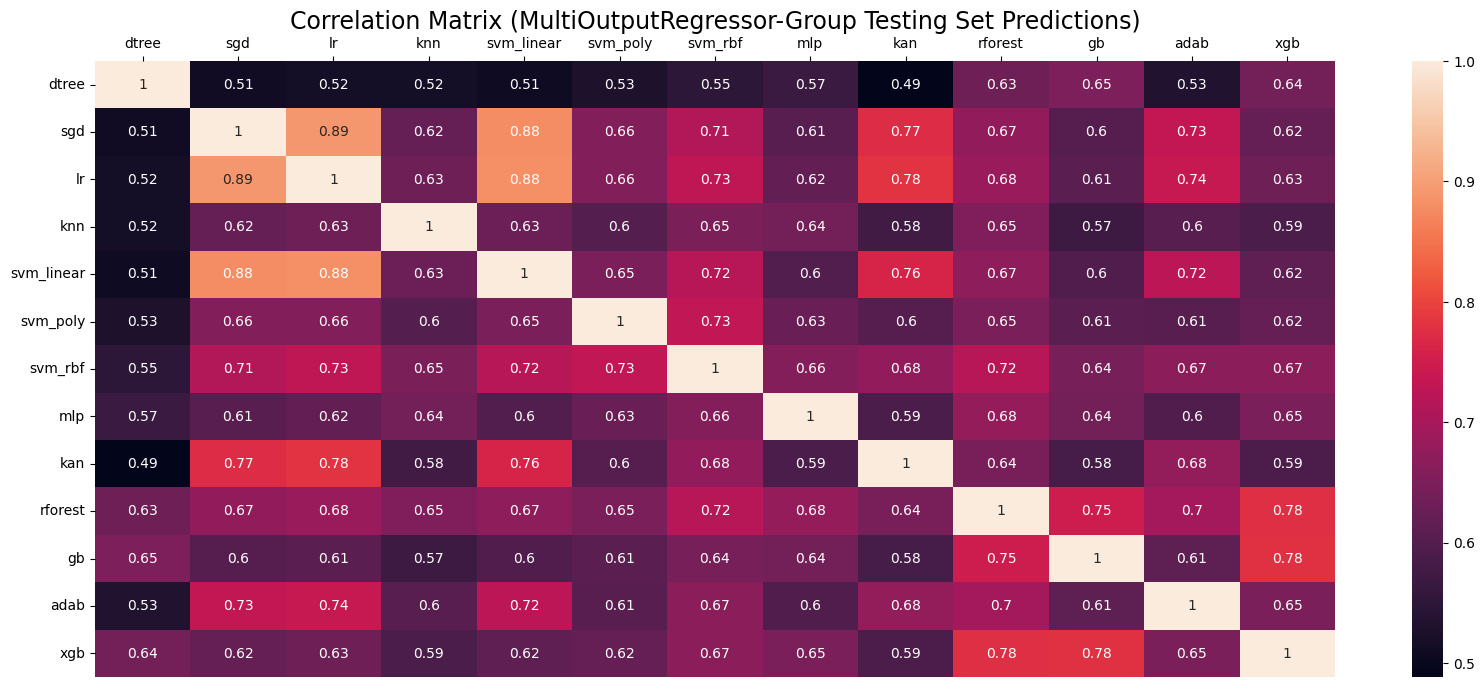

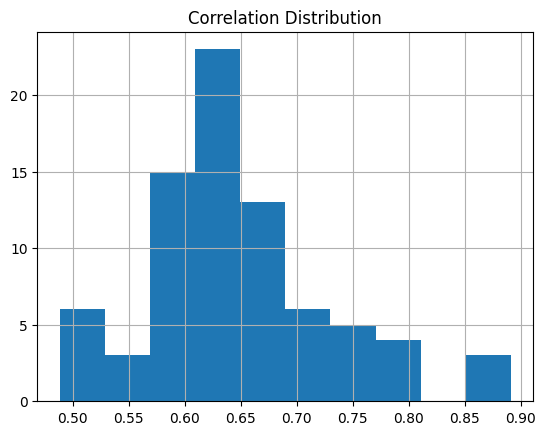

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0124
NMSE: 0.1116
MAE: 0.0983
NMSE: 0.6700
Desvio Padrão: 0.0634


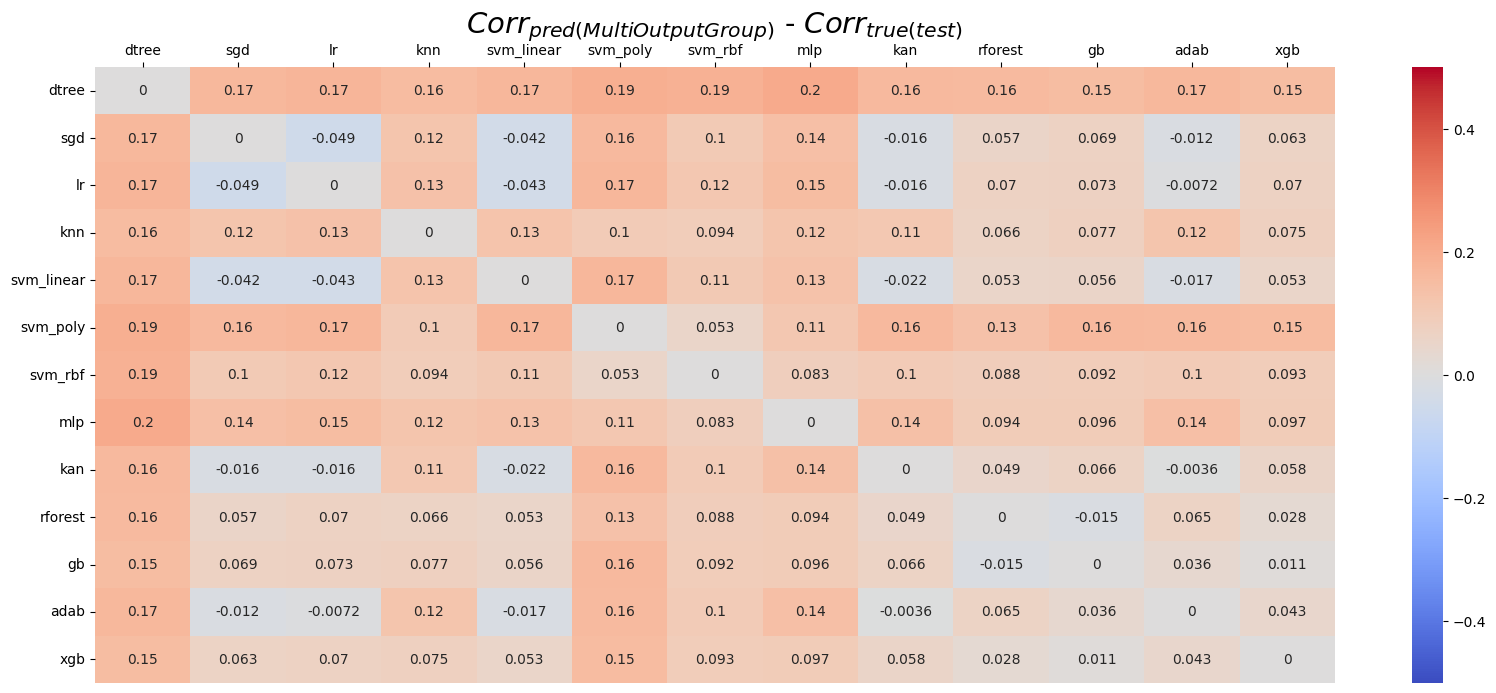

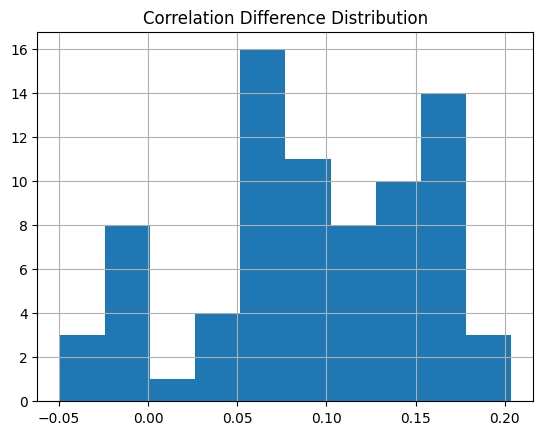

[Saved image "cm_morgtest.eps"]
[Saved image "cd_morgtest.eps"]
[Saved image "cmd_mog.eps"]
[Saved image "cdd_mog.eps"]


In [207]:
morGroups_corrls = y_pred.corr('kendall')
#pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-output(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-output(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-output(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-output(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(morGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm1)

plt.title('Correlation Distribution')
hg1 = corrlArray(morGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = morGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutputGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

save2figs(hm1, hg1, 'churn')
save2figs(hm2, hg2, 'churn')

## Análises

In [99]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE      RMSE       MAE      NMSE
0              regchain  dtree  0.178037  0.421944  0.334889  0.891180
1          multi-output  dtree  0.178037  0.421944  0.334889  0.891180
2            individual  dtree  0.172037  0.414774  0.342495  0.861147
3       regchain(group)  dtree  0.178037  0.421944  0.334889  0.891180
4   multi-output(group)  dtree  0.178037  0.421944  0.334889  0.891180
..                  ...    ...       ...       ...       ...       ...
60             regchain    xgb  0.090028  0.300046  0.221406  0.784187
61         multi-output    xgb  0.091512  0.302509  0.215301  0.797117
62           individual    xgb  0.085556  0.292500  0.210813  0.745241
63      regchain(group)    xgb  0.092046  0.303392  0.222521  0.801773
64  multi-output(group)    xgb  0.091512  0.302509  0.215301  0.797117

[65 rows x 6 columns]

In [211]:
teste = metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
#teste.to_csv('data/churn/results.csv')
teste

MSE                RMSE                 MAE  \
                         mean       std      mean       std      mean   
assessor_type                                                           
individual           0.071116  0.048705  0.246728  0.105331  0.182950   
multi-output         0.075682  0.051184  0.254734  0.108131  0.184124   
multi-output(group)  0.075682  0.051184  0.254734  0.108131  0.184124   
regchain             0.074485  0.050761  0.252606  0.107541  0.187784   
regchain(group)      0.075407  0.051406  0.254048  0.108501  0.185729   

                                   NMSE            
                          std      mean       std  
assessor_type                                      
individual           0.088777  0.659818  0.166533  
multi-output         0.088688  0.704434  0.174378  
multi-output(group)  0.088688  0.704434  0.174378  
regchain             0.088685  0.693049  0.170115  
regchain(group)      0.088133  0.700370  0.176922

In [101]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

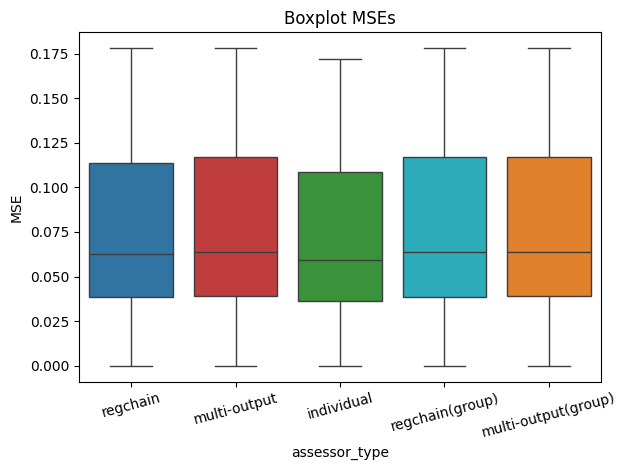

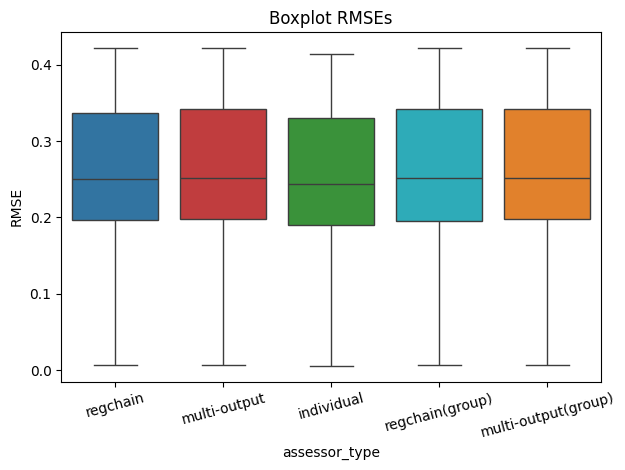

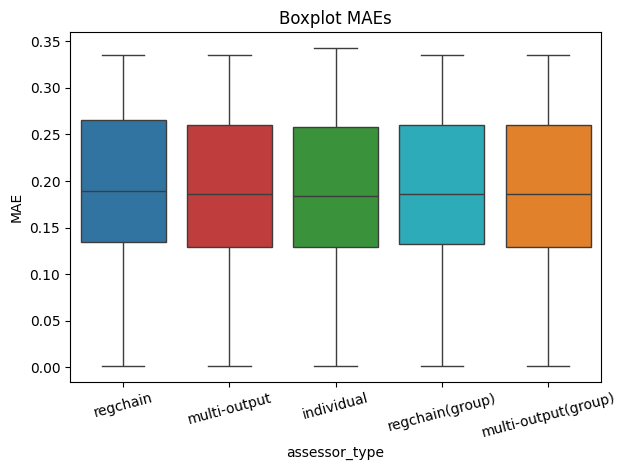

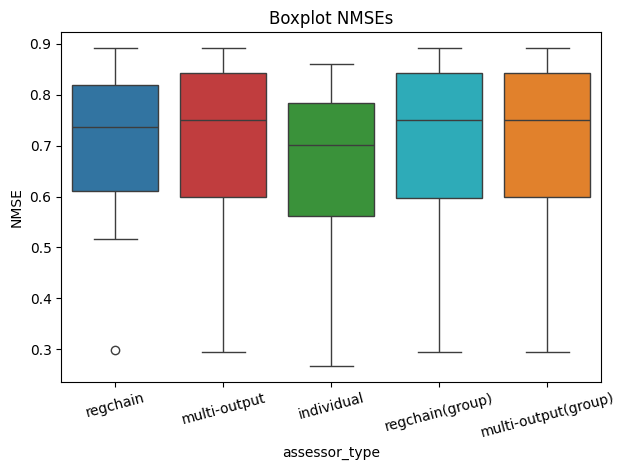

In [213]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    imgplt = sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/churn/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

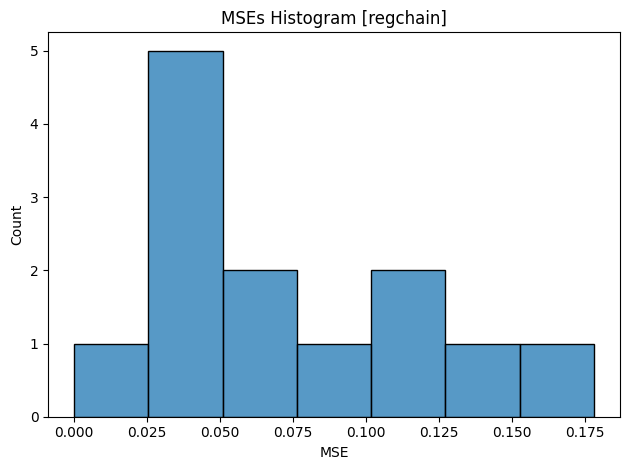

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


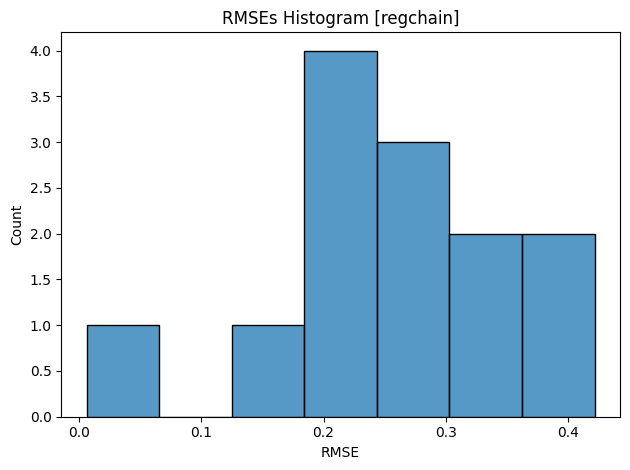

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


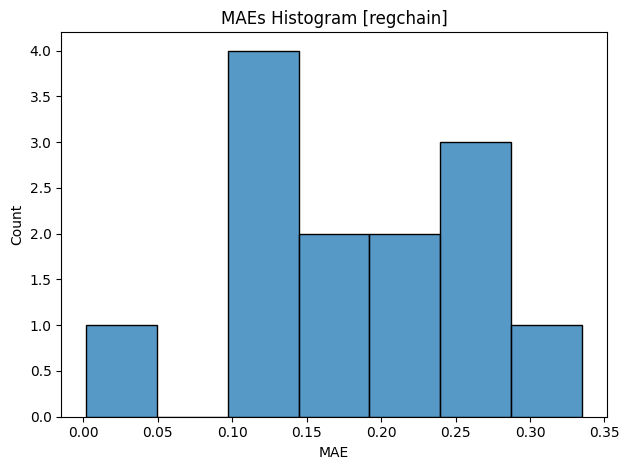

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


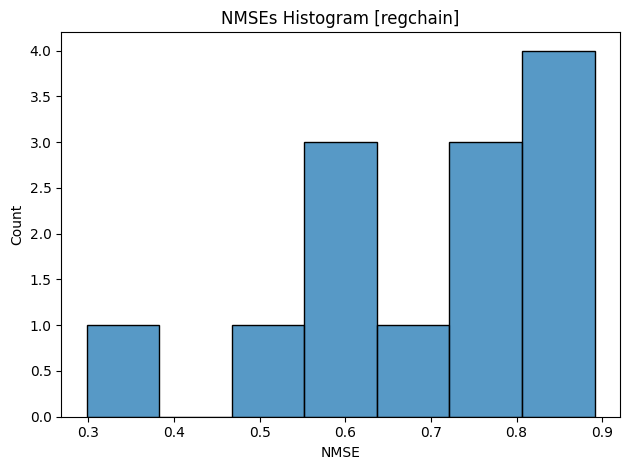

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


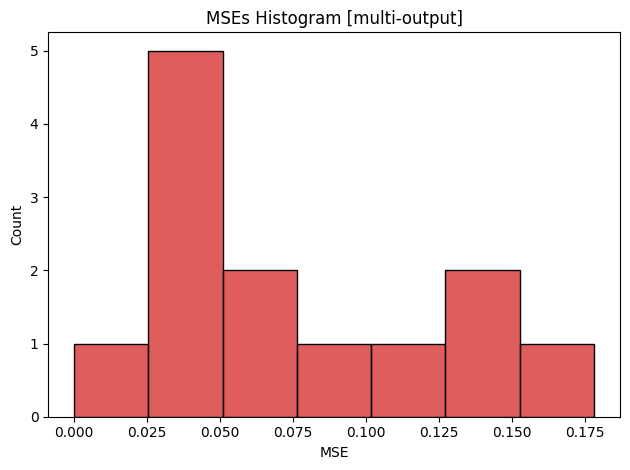

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


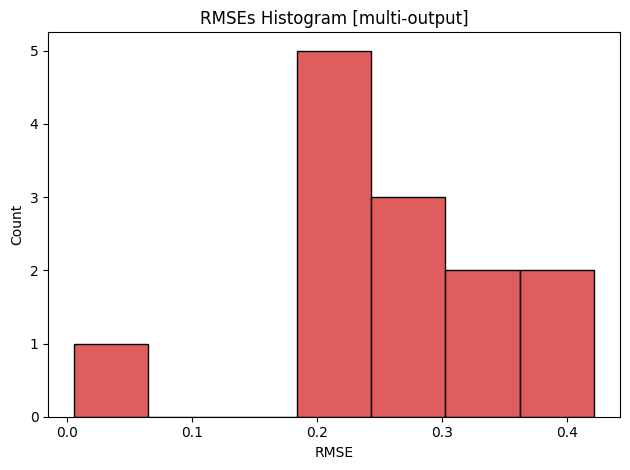

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


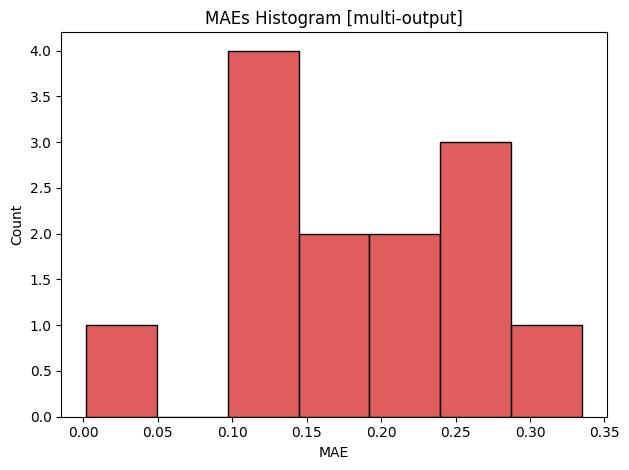

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


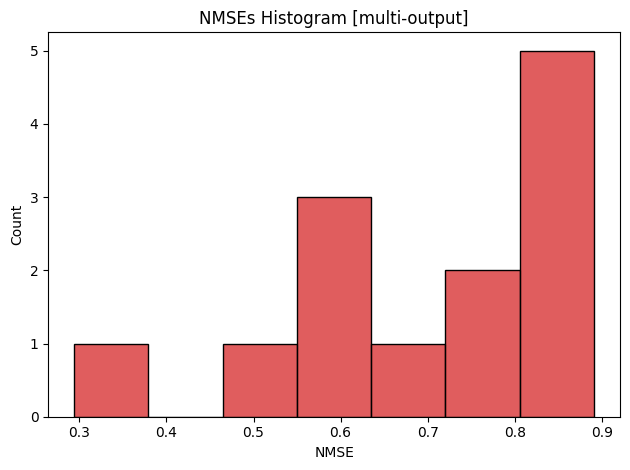

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


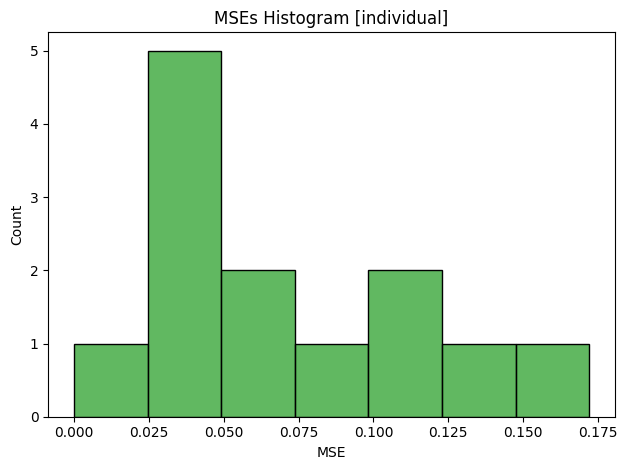

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


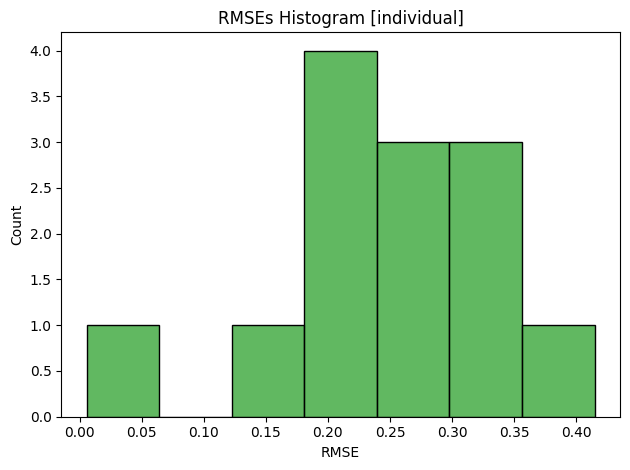

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


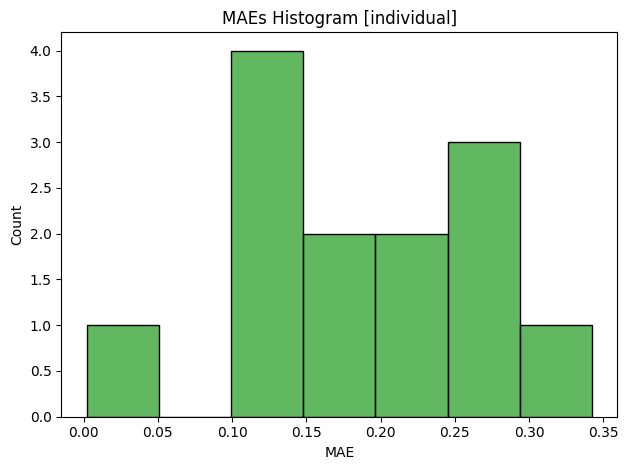

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


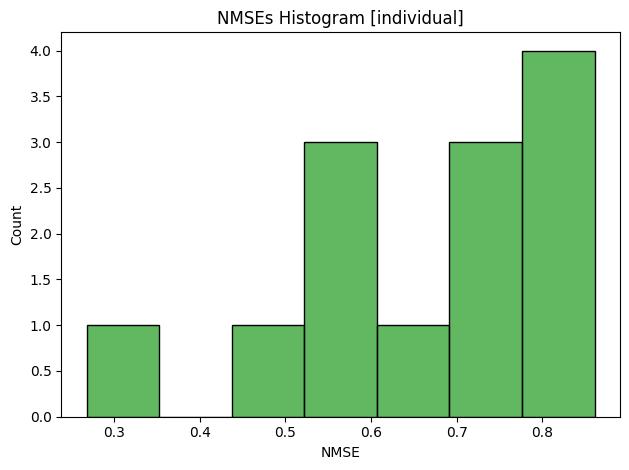

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


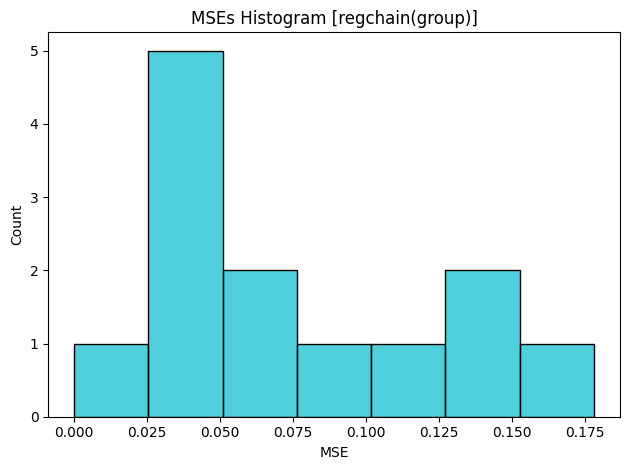

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


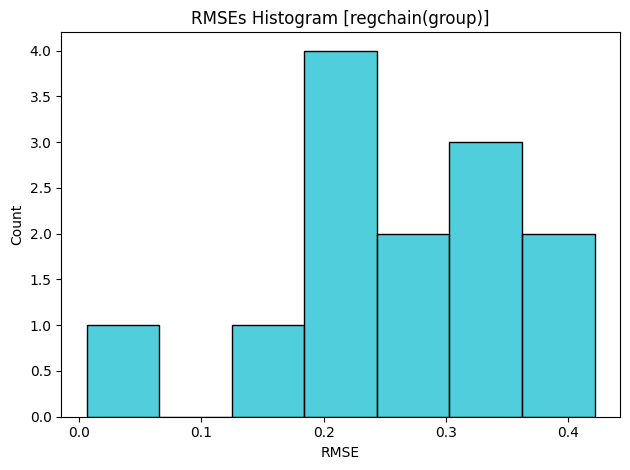

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


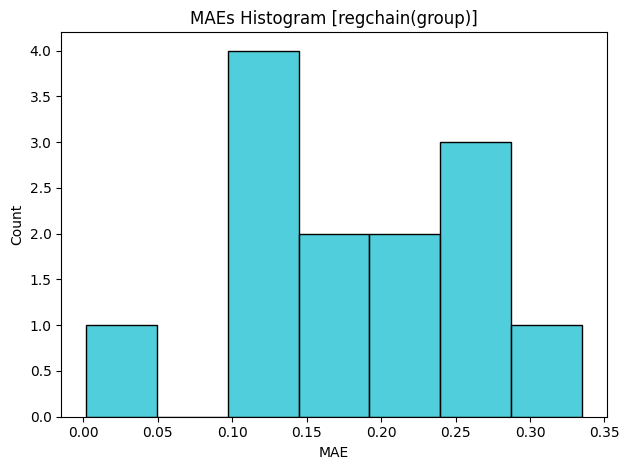

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


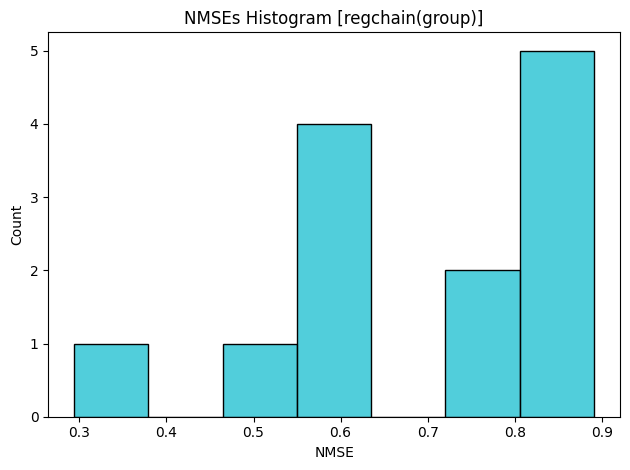

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


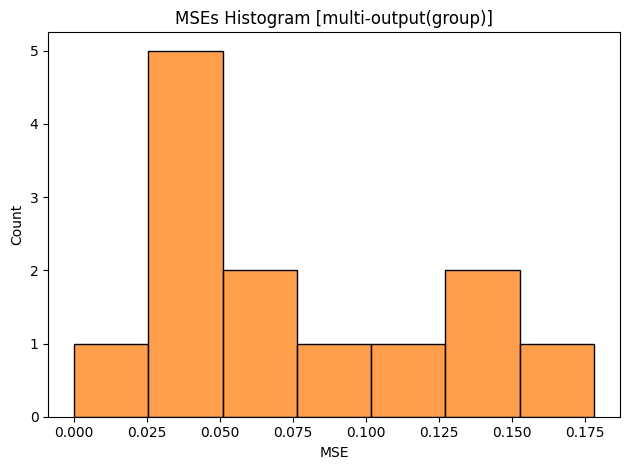

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


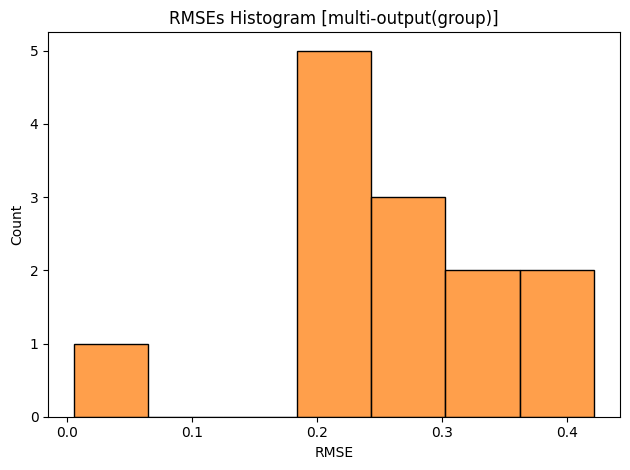

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


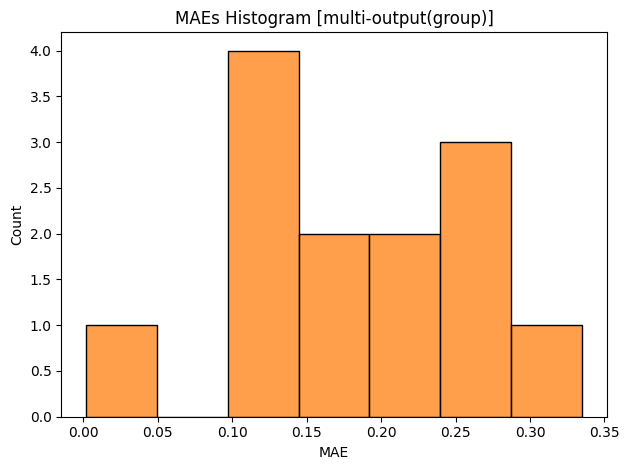

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


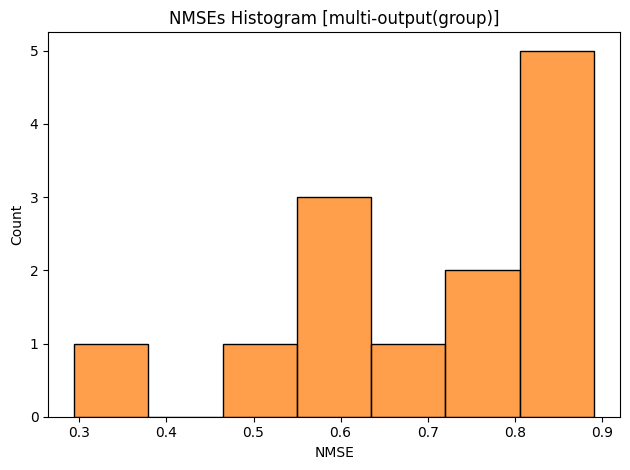

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
dicio = {'regchain': {'color': class_palette[0], 'code': 'rc'},
         'multi-output': {'color': class_palette[1], 'code': 'mor'},
         'individual': {'color': class_palette[2], 'code': 'ia'},
         'regchain(group)': {'color': class_palette[3], 'code': 'rcg'},
         'multi-output(group)': {'color': class_palette[4], 'code': 'morg'}}

for a in dicio.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/churn/imgs/hg_{dicio[a]['code']}_{mt.lower()}.eps', format='eps', dpi=300)

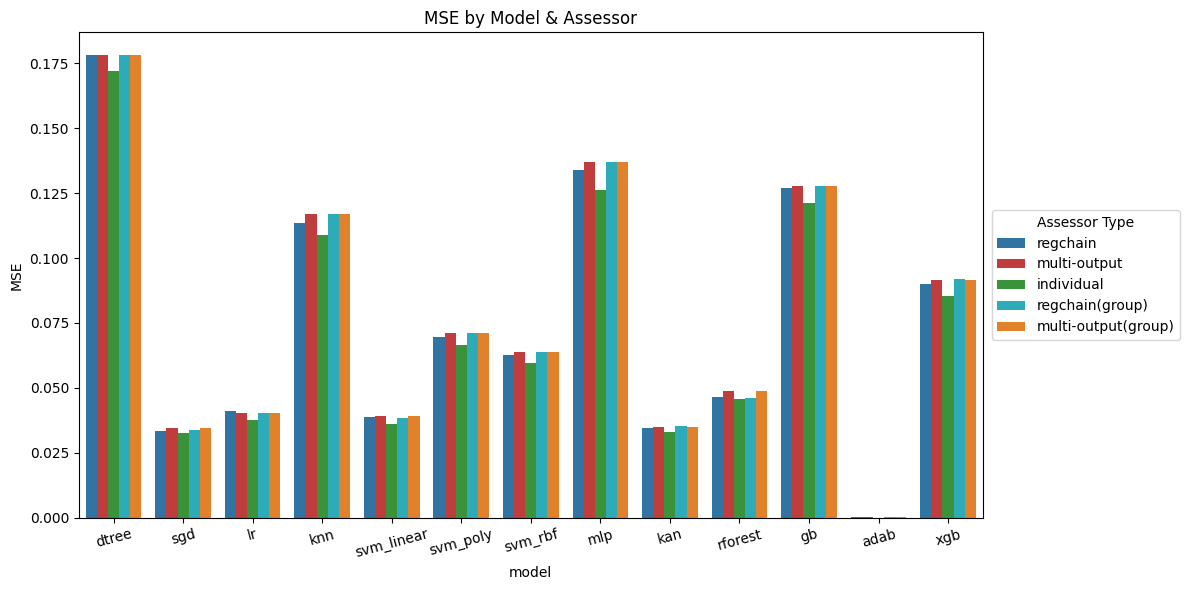

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


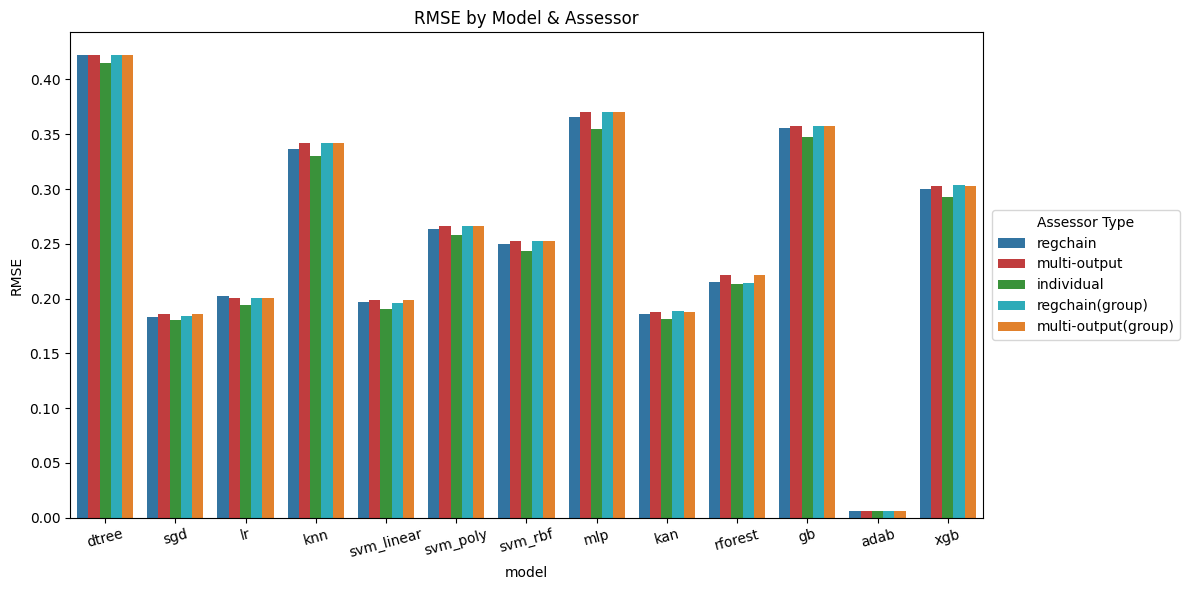

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


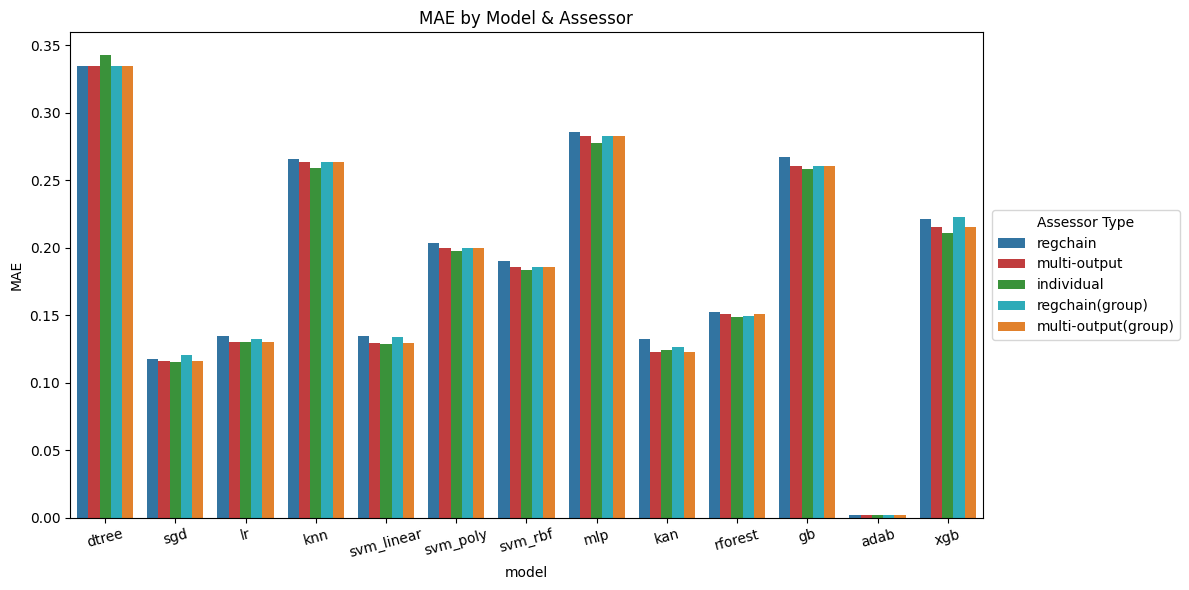

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


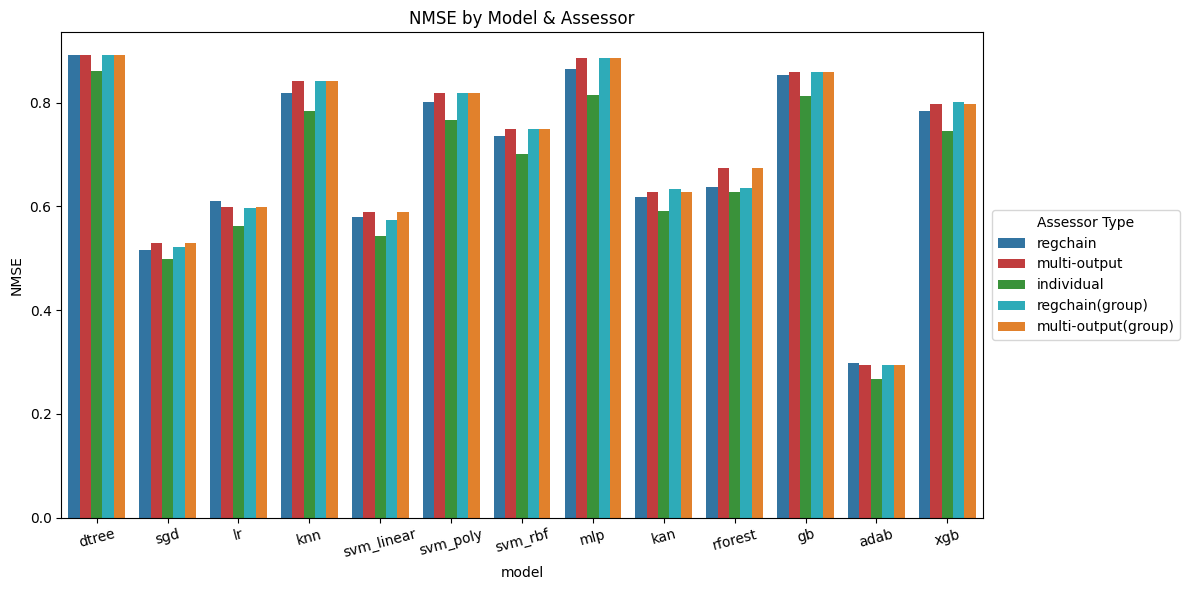

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [235]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/churn/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)